# DISCLAIMER

After submitting my notebook and receiving feedback, I worked on it again with the feedback and the help of a classmate Brandon Foo.

# ASTR3110 Computer Laboratory 1: The Period-Luminosity relation using Cepheid variable stars from Gaia.


In this lab, you will use data from the Gaia Data Release 2 (Gaia DR2) to calibrate the Type I Cepheid period-luminosity relation, also known as the "Leavitt's law" honouring Henrietta Swan Leavitt who first discovered the relation using Cepheids in the Small Magellanic Cloud. We discussed the Period-Luminosity relation for Type I Cepheids in the Week 2 lectures.

In the first part of the lab, you will hone your data massaging skills, using Pandas to weed out bad data in order to select a high-fidelity sample of Type I Cepheids (also known as Delta Cepheids or Classical Cepheids) ready for calibrating the Leavitt law. You will determine which of the paramters are required for measuring Leavitt's law, and also calculate the required new quantities and associated uncertainties.

In the second part of the lab, you will use your knowledge of fitting data to determine the best-fitting straight-line parameterisation of Leavitt's Law. You will use two methods to do this: standard optimisation and MCMC. You will compare the results from the two methods, and also compare the results of the two different measurements of distance derived from the Gaia parallax measurements.

In the third part of the lab, you will use your calibrated Leavitt Law to determine the distance to the Large Magellanic Cloud.

At the completion of this lab, you will have acquired (or improved) the following skills:
- Data filtering using Pandas.
- Manipulating data to derive required parameters.
- Plotting data and interpreting plots.
- Fitting models to data using standard optimisation and MCMC.

You will need to turn in your completed notebook for marking (details will appear on iLearn later). You will be marked on the following with equal weight:
- Comments: Your code must be commented. You can either do this by adding explanation text placed in blocks just before code blocks OR as comments within the code blocks themselves. Your comments should demonstrate that you understand what your code is doing, and why! You will be marked based on the clarity of your comments, and whether your comments indicate that you understand your code.
- Plots should be well presented and explained: E.g., reasonable axes (e.g., ranges should be set so that trends are clearly visible), clear axis labels. You should also explain the "why" and "what" of your plots. Why are you plotting this? What does your plot show?
- Formatting of your code (easy to understand, sensible variable names etc.)
- Explanations and/or justification for cuts made on the data.
- Comments/answers to any questions posed in the notebooks as well as comments on interpretation/comparison of results. E.g., how does your determined LMC distance compare with your expectations?

lab1 recording has an explanation of what each criteria means.

Can get the meaning of each column name from the gaia archive website

# 1. Obtaining the data and applying basic filters

In this part, we will retrieve the Gaia data from the archive, and weed out obviously bad data.

## Downloading the data

The data for this practical comes from the [Gaia](https://www.cosmos.esa.int/web/gaia/) mission and must be downloaded from the online Gaia archive at [http://gea.esac.esa.int/archive/](http://gea.esac.esa.int/archive/). The tabular data is retrieved from the database via an astronomy data query language (ADQL) statement:

```
SELECT source_id, dist.r_est, dist.r_lo, dist.r_hi, dist.r_len, dist.result_flag, dist.modality_flag, src.ra, src.dec, src.L, src.B, src.parallax, src.parallax_error, cep.type_best_classification, cep.mode_best_classification, cep.pf, cep.pf_error, cep.int_average_bp, cep.int_average_bp_error, cep.int_average_g, cep.int_average_g_error, cep.int_average_rp, cep.int_average_rp_error, cep.g_absorption,cep.g_absorption_error,cep.num_clean_epochs_g
FROM external.gaiadr2_geometric_distance as dist
JOIN gaiadr2.vari_cepheid AS cep USING (source_id)
JOIN gaiadr2.gaia_source AS src USING (source_id)
```

This query selects multiple columns from 3 tables in the archive that are merged using a common ```source_id``` column. We will describe what each of the columns contains later in this notebook.

At the Gaia archive page linked above, go to Search -> Advanced (ADQL) and copy the query into the box. Run the query and when finished save locally using the download icon on the right in the job window. Once you have the file on your local disk, you will need to upload to your google drive in order to allow Colab to access the data. Save the file to the same working directory that your Lab 1 python notebook is stored in. Note that the downloaded file compressed as a 'GZIP' archive.

In the cell below, import your google drive so that Colab can access the data there (see instructions at [link](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/SETUP_COLAB.md)). Change to the directory that the Gaia data are saved under, and unzip the file using the command ```!gunzip <filename.gz>``` in a cell. Double check to make sure all has gone to plan (e.g., run the !ls command to list the files in your current directory).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/'My Drive'/'ASTR3110'/'OLD'/'Prac01'

/content/gdrive/My Drive/ASTR3110/OLD/Prac01


## Inspecting the data


The tabular data is in an XML-like format called 'VOTable', where VO stands for 'virtual observatory'. Dedicated software like [TOPCAT](http://www.star.bris.ac.uk/~mbt/topcat/) can be used to view, manipulate and plot the data. However, for our analysis we will convert the table to a [Pandas](https://pandas.pydata.org/) dataframe. As you will recall from the second lectorial, Pandas is a high-performance module for doing data analysis with Python and is used widely outside of astronomy.

In [ ]:
# Start by importing necessary Python modules
from astropy.io.votable import parse
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Installing a package that allows equation numbering, retrieved from [here](https://stackoverflow.com/questions/41241984/equation-numbering-in-jupyter-notebooks)

In [ ]:
pip install jupyter_contrib_nbextensions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.5 MB 1.7 MB/s 
     |████████████████████████████████| 481 kB 55.3 MB/s 
     |████████████████████████████████| 273 kB 60.3 MB/s 
     |████████████████████████████████| 439 kB 58.9 MB/s 
     |████████████████████████████████| 71 kB 14 kB/s 
     |████████████████████████████████| 133 kB 79.2 MB/s 
     |████████████████████████████████| 107 kB 56.5 MB/s 
     |████████████████████████████████| 92 kB 904 kB/s 
     |████████████████████████████████| 423 kB 72.2 MB/s 
     |████████████████████████████████| 9.8 MB 46.1 MB/s 
     |████████████████████████████████| 346 kB 66.8 MB/s 
     |████████████████████████████████| 55 kB 3.2 MB/s 
     |████████████████████████████████| 80 kB 9.6 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 1.6 MB 43.4 MB/s 
  Created wheel for jupyter-contrib-nbexte

creating a function to read in the downloaded data from the Gaia website.

In [ ]:
# Define a function to read a VOTable and return a DataFrame
def votable_to_pandas(voTabFileName, indx=0):
    """
    Reads a VOTable file and returns a Pandas dataframe.
    Reads only one sub-table, specified by the indx argument.
    """

    # Parse the VOTable into a table tree & convert 1st sub-table to an AstroPy table
    voTabTree = parse(voTabFileName)
    apTab = voTabTree.get_table_by_index(indx).to_table(use_names_over_ids=True)

    return apTab.to_pandas()

Now we run our conversion function on the VOTable to read the table into memory. The converter may issue a few warnings, but these can be safely ignored. In the cell below, use the function defined above to read you VOTable into a Pandas DataFrame.

In [ ]:
myData= votable_to_pandas('Data/lab1Data.gz',)

We can inspect the format of the table using the ```head()``` method of the dataframe ('methods' are functions that live inside python 'objects', like tables, and operate only on the parent object). In the cell below, print the first 10 rows.

In [ ]:
myData.head()
#prints the first 10 rows so we can see the structure of our DF

,source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,ra,dec,l,...,pf_error,int_average_bp,int_average_bp_error,int_average_g,int_average_g_error,int_average_rp,int_average_rp_error,g_absorption,g_absorption_error,num_clean_epochs_g
0,4052922352453886976,10053.713376,7757.045820,13433.287852,2033.675494,1,1,275.945268,-25.672356,7.001862,...,0.000829,15.422571,0.003206,14.559613,0.000121,13.630170,0.003486,NaN,NaN,19
1,4103564728516764032,7524.096688,5939.009081,9900.642710,1810.259735,1,1,280.454570,-14.505427,18.916709,...,0.000204,14.575795,0.003055,13.647923,0.002157,12.940319,0.001979,NaN,NaN,17
2,4102332175955773568,4614.365023,3547.219238,6390.505312,1889.453036,1,1,284.202140,-13.622576,21.343833,...,0.000340,16.816808,0.018745,16.260889,0.000530,15.518061,0.010214,NaN,NaN,18
3,4103813802261866496,1584.494997,1443.906220,1754.713873,1784.169454,1,1,280.344007,-13.841397,19.461784,...,0.000056,10.297049,0.000359,9.721283,0.000280,9.025764,0.000337,NaN,NaN,13
4,4103989346187406464,2201.676060,1958.923325,2510.741533,1568.626074,1,1,276.806044,-15.117989,16.752307,...,0.000043,10.940114,0.000439,10.069065,0.000194,9.178810,0.000208,NaN,NaN,18


Note that the leftmost column above displays the row-index of the table. This can be an integer (as above) or a text field. We can see that there are a large number of columns, so the ```head()``` method does not display them all. We can print all the column names like this "gaiaDF.columns". In the cell below, write a for loop that loops through the columns and prints the column number and name.

In [ ]:
myData.columns

Index(['source_id', 'r_est', 'r_lo', 'r_hi', 'r_len', 'result_flag',
       'modality_flag', 'ra', 'dec', 'l', 'b', 'parallax', 'parallax_error',
       'type_best_classification', 'mode_best_classification', 'pf',
       'pf_error', 'int_average_bp', 'int_average_bp_error', 'int_average_g',
       'int_average_g_error', 'int_average_rp', 'int_average_rp_error',
       'g_absorption', 'g_absorption_error', 'num_clean_epochs_g'],
      dtype='object')

confirming the syntax... going to enumerate through the columns to check that `columns` provides the columns in order:

In [ ]:
for columnIndex, columnName in enumerate(myData.columns):
    print(columnIndex, columnName)


0 source_id
1 r_est
2 r_lo
3 r_hi
4 r_len
5 result_flag
6 modality_flag
7 ra
8 dec
9 l
10 b
11 parallax
12 parallax_error
13 type_best_classification
14 mode_best_classification
15 pf
16 pf_error
17 int_average_bp
18 int_average_bp_error
19 int_average_g
20 int_average_g_error
21 int_average_rp
22 int_average_rp_error
23 g_absorption
24 g_absorption_error
25 num_clean_epochs_g


The meanings of the column names can be found in the [GAIA data model documentation](http://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/) or viewed as hover help text on the sidebar of the GAIA query page:

![archive_hover_description.png](attachment:archive_hover_description.png)

An important part of both data science and astro research is *understanding* the data you are using. Using the information at the Gaia webpage, make a new markdown cell where you list each column in the DataFrame, along with a short description of the data contained in the column of interest (be sure to note units in your description!).

### Column definitions:
* source_id : A uniqe identifier for the source.


* r_est : Estimated distance (parsecs)


* r_lo : Lower bound on the confidence interval of the estimated distnace (parsecs)


* r_hi : Upper bound on the confidence interval of the estimated distance (parsecs)


* r_len : Length scale used in the prior for the distance estimation (parsecs)


* result_flag : Three possible values: 0 = failed estimate (r_est, r_lo, r_hi are all null) ; 1 = r_est is the mode (highest if the posterior is bimodal); r_lo/r_hi define the lower/upper limits of the highest density interval (HDI) containing 68% of the posterior probability ; 2 = r_est is the median; r_lo/r_hi define the lower/upper limits of the equal-tailed interval (ETI), containing 68% of the posterior probability.


* modality_flag : The number of modes in the posterior (1 or 2 from result_flag)


* ra : Right ascension (degrees)


* dec : Declination (degrees)


* l : Galactic longitude (degrees)


* b : Galactic latitude (degrees)


* parallax : The parallax angle of the source (mas)


* parallax_error : The error in parallax angle of the source (mas)


* type_best_classification : Best type classification estimate out of: {"DCEP", "T2CEP", "ACEP"}


* mode_best_classification : Best mode classification estimate out of: { "FUNDAMENTAL", "FIRST_OVERTONE","SECOND_OVERTONE","MULTI,"UNDEFINED","NOT_APPLICABLE"}


* pf : Period corresponding to the fundamental pulsation mode (for multi mode pulsators) in the G band time series (days)
                     
                     
* pf_error : Uncertainty of the pf period (days)


* int_average_bp : intensity-averaged magnitude in the BP band (magnitude)


* int_average_bp_error : Uncertainty on int_average_bp parameter (magnitude)


* int_average_g : Intensity-averaged magnitude in the G band (magnitude)


* int_average_g_error : Uncertainty on int_average_g parameter (magnitude)


* int_average_rp : intensity-averaged magnitude in the RP band (magnitude)


* int_average_rp_error : Uncertainty on int_average_rp parameter (magnitude)


* g_absorption : Interstellar absorption in the G-band (magnitude)


* g_absorption_error : Error on the interstellar absorption in the G-band (magnitude)


* num_clean_epochs_g : Number of G FoV epochs used in the fitting algorithm




## Preliminary Filtering of the Data


Now that we know what the data are, we can remove those rows with missing/Null/NaN/Inf values. In the code cell below, use you knowledge of Pandas funtions to list the number of null values for each column.


In [ ]:
pd.options.mode.use_inf_as_na = True
myData.isnull().sum()
#the entire column of g_absorption and g_absorption_error are full of nulls. There are a few
#other columns with a lot of nulls.



source_id                      0
r_est                          0
r_lo                           0
r_hi                           0
r_len                          0
result_flag                    0
modality_flag                  0
ra                             0
dec                            0
l                              0
b                              0
parallax                       0
parallax_error                 0
type_best_classification       0
mode_best_classification       0
pf                          3639
pf_error                    3639
int_average_bp              1105
int_average_bp_error        1105
int_average_g                  0
int_average_g_error            0
int_average_rp              1105
int_average_rp_error        1105
g_absorption                9570
g_absorption_error          9570
num_clean_epochs_g             0
dtype: int64

After inspecting the number of null values, determine your course of action for removing them. In some cases, you may need to remove entire columns; use the appropriate Pandas column operators to do so. In other cases, you will need to produce a mask that selects only the offending rows and removes them. Be sure to check that your code is doing what you think it is (e.g., inspect the length of newly produced data frames, columns are removed, and that the final data frame no longer contains nulls).

Note, we should not include the gabsorption and error columns in the mask because the entirety of those columns in the DF is NAN so when applying the mask to the DF it will make a new one with no data in it.

In [ ]:
mask = myData['pf'].isnull() | myData['pf_error'].isnull() | myData['int_average_bp'].isnull() | myData['int_average_bp_error'].isnull() | myData['int_average_rp'].isnull() | myData['int_average_rp_error'].isnull()
#creating the mask variable to hold all the columns with null values.

cleanData=myData[~mask] #applying the mask to the DF so that the new DF contains everything BUT the mask.
cleanData


,source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,ra,dec,l,...,pf_error,int_average_bp,int_average_bp_error,int_average_g,int_average_g_error,int_average_rp,int_average_rp_error,g_absorption,g_absorption_error,num_clean_epochs_g
0,4052922352453886976,10053.713376,7757.045820,13433.287852,2033.675494,1,1,275.945268,-25.672356,7.001862,...,8.292019e-04,15.422571,0.003206,14.559613,0.000121,13.630170,0.003486,NaN,NaN,19
1,4103564728516764032,7524.096688,5939.009081,9900.642710,1810.259735,1,1,280.454570,-14.505427,18.916709,...,2.038922e-04,14.575795,0.003055,13.647923,0.002157,12.940319,0.001979,NaN,NaN,17
2,4102332175955773568,4614.365023,3547.219238,6390.505312,1889.453036,1,1,284.202140,-13.622576,21.343833,...,3.398253e-04,16.816808,0.018745,16.260889,0.000530,15.518061,0.010214,NaN,NaN,18
3,4103813802261866496,1584.494997,1443.906220,1754.713873,1784.169454,1,1,280.344007,-13.841397,19.461784,...,5.583391e-05,10.297049,0.000359,9.721283,0.000280,9.025764,0.000337,NaN,NaN,13
4,4103989346187406464,2201.676060,1958.923325,2510.741533,1568.626074,1,1,276.806044,-15.117989,16.752307,...,4.338303e-05,10.940114,0.000439,10.069065,0.000194,9.178810,0.000208,NaN,NaN,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9564,4688317546477243904,4971.776192,3957.051422,6327.109886,629.252076,1,1,4.132807,-74.250035,306.142269,...,1.101993e-05,17.637455,0.006037,17.366874,0.000824,16.898184,0.006627,NaN,NaN,26
9566,5864135319959353600,4489.321528,3850.622703,5359.322671,1638.294878,1,1,204.153660,-64.558316,307.761442,...,1.091946e-03,10.179677,0.000394,9.100291,0.000248,8.118965,0.000167,NaN,NaN,38
9567,5863815636949490048,12175.188849,9506.290924,15815.499245,1759.835188,1,1,202.865516,-65.327202,307.096158,...,8.835222e-06,16.554841,0.002620,15.683962,0.000419,14.745969,0.002199,NaN,NaN,37
9568,6061694950707440512,3419.120519,2618.499592,4758.028529,1392.690485,1,1,192.854272,-55.366802,302.928935,...,4.752223e-05,17.503591,0.001362,16.794087,0.000111,15.854118,0.000619,NaN,NaN,92


In [ ]:
cleanData.isnull().sum()
#now removing the two g abs columns as they are nothing but NANs, therefore no useful information
cleanData.pop("g_absorption")
cleanData.pop("g_absorption_error")

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9564   NaN
9566   NaN
9567   NaN
9568   NaN
9569   NaN
Name: g_absorption_error, Length: 5335, dtype: float64

now lets confirm there are no more NAN values

In [ ]:
cleanData.isnull().sum()

source_id                   0
r_est                       0
r_lo                        0
r_hi                        0
r_len                       0
result_flag                 0
modality_flag               0
ra                          0
dec                         0
l                           0
b                           0
parallax                    0
parallax_error              0
type_best_classification    0
mode_best_classification    0
pf                          0
pf_error                    0
int_average_bp              0
int_average_bp_error        0
int_average_g               0
int_average_g_error         0
int_average_rp              0
int_average_rp_error        0
num_clean_epochs_g          0
dtype: int64

# 2. Selection of Classical Cepheids


During the query of the Gaia archive, we also cross matched to the gaiadr2.vari_cepheid catalogue. This catalogue contains information on Cepheid varible stars including classification of the pulsation mode and the Cepheid type. Use Pandas "groupby" functionality to look at the different classifications.

In [ ]:
cleanData.groupby('type_best_classification').describe() #calling the cepheids

source_id                                            \
                             count          mean           std           min   
type_best_classification                                                       
ACEP                          49.0  4.771470e+18  2.271755e+17  4.651062e+18   
DCEP                        4741.0  4.531157e+18  9.919304e+17  4.527067e+16   
T2CEP                        545.0  4.387772e+18  1.593578e+18  9.938441e+16   

                                                                    \
                                   25%           50%           75%   
type_best_classification                                             
ACEP                      4.661460e+18  4.685543e+18  4.689155e+18   
DCEP                      4.657246e+18  4.685686e+18  4.688856e+18   
T2CEP                     4.043822e+18  4.657943e+18  5.520441e+18   

                                         r_est               ...  \
                                   max   count         mean  ...   
type_best_classification                                     ...   
ACEP                      5.283188e+18    49.0  3968.631744  ...   
DCEP                      6.904302e+18  4741.0  6318.755025  ...   
T2CEP                     6.903018e+18   545.0  5135.545898  ...   

                         int_average_rp_error           num_clean_epochs_g  \
                                          75%       max              count   
type_best_classification                                                     
ACEP                                 0.011456  0.021921               49.0   
DCEP                                 0.004455  0.178661             4741.0   
T2CEP                                0.003231  0.204123              545.0   

                                                                               
                               mean        std   min   25%   50%   75%    max  
type_best_classification                                                       
ACEP                      40.142857  21.879404  21.0  27.0  30.0  48.0  108.0  
DCEP                      34.159249  18.713546  12.0  26.0  29.0  32.0  204.0  
T2CEP                     31.370642  17.706405  13.0  21.0  28.0  36.0  152.0  

[3 rows x 176 columns]

D = delta cephied, classical or type 1 are based off the Dcep. We use Dcep to find the luminosity-period relationships since they're the brightest so act as candles.


In [ ]:
cleanData.groupby('mode_best_classification').describe() #calling the modes

source_id                                            \
                             count          mean           std           min   
mode_best_classification                                                       
FUNDAMENTAL                 4553.0  4.530613e+18  9.917849e+17  4.527067e+16   
MULTI                        237.0  4.591279e+18  8.990134e+17  6.996973e+16   
NOT_APPLICABLE               545.0  4.387772e+18  1.593578e+18  9.938441e+16   

                                                                    \
                                   25%           50%           75%   
mode_best_classification                                             
FUNDAMENTAL               4.657245e+18  4.685679e+18  4.688856e+18   
MULTI                     4.658004e+18  4.685879e+18  4.688958e+18   
NOT_APPLICABLE            4.043822e+18  4.657943e+18  5.520441e+18   

                                         r_est               ...  \
                                   max   count         mean  ...   
mode_best_classification                                     ...   
FUNDAMENTAL               6.904302e+18  4553.0  6347.742373  ...   
MULTI                     6.744482e+18   237.0  5275.989473  ...   
NOT_APPLICABLE            6.903018e+18   545.0  5135.545898  ...   

                         int_average_rp_error           num_clean_epochs_g  \
                                          75%       max              count   
mode_best_classification                                                     
FUNDAMENTAL                          0.004310  0.178661             4553.0   
MULTI                                0.006821  0.059081              237.0   
NOT_APPLICABLE                       0.003231  0.204123              545.0   

                                                                               
                               mean        std   min   25%   50%   75%    max  
mode_best_classification                                                       
FUNDAMENTAL               34.262684  18.692403  12.0  26.0  29.0  33.0  204.0  
MULTI                     33.409283  19.956234  15.0  26.0  29.0  31.0  183.0  
NOT_APPLICABLE            31.370642  17.706405  13.0  21.0  28.0  36.0  152.0  

[3 rows x 176 columns]

We want to use Dcep and the fundamental columns. We will need to make a mask to only consider those two.

Filter your catalogue so that it contains only Classical Cepheids (DCEP) observed during their Fundamental pulsation mode. These are the Cepheids that we will use for the remainder of the prac.

now lets check where DCEP and fundamental are located in the DF so we can extract  the index to apply to the mask. We have to do this because simply copying and pasting the DCEP and FUNDAMENTAL mode from the tables above won't work in the mask.

In [ ]:
cleanData['type_best_classification'] #finding the index that contains the classification we want.
#index 0 has delta cepheids, so we will use this index later.

0       DCEP
1       DCEP
2       DCEP
3       DCEP
4       DCEP
        ... 
9564    DCEP
9566    DCEP
9567    DCEP
9568    DCEP
9569    DCEP
Name: type_best_classification, Length: 5335, dtype: object

In [ ]:
cleanData['mode_best_classification']
#finding the index that contains the mode we want.
#index 0 has the mode we want, so we will use this index later.

0       FUNDAMENTAL
1       FUNDAMENTAL
2       FUNDAMENTAL
3       FUNDAMENTAL
4       FUNDAMENTAL
           ...     
9564    FUNDAMENTAL
9566    FUNDAMENTAL
9567    FUNDAMENTAL
9568    FUNDAMENTAL
9569          MULTI
Name: mode_best_classification, Length: 5335, dtype: object

We can see the index for both is 0, now apply it to the mask so that it only includes DCEP and FUNDAMENTAL

In [ ]:
cepMask = (cleanData['type_best_classification'] == cleanData['type_best_classification'][0])& (cleanData['mode_best_classification']== cleanData['mode_best_classification'][0])
#creating a mask that contains only the modes anbd classification we want.
#Noting the index 0 has been called

cepData= cleanData[cepMask]

cepData


,source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,ra,dec,l,...,mode_best_classification,pf,pf_error,int_average_bp,int_average_bp_error,int_average_g,int_average_g_error,int_average_rp,int_average_rp_error,num_clean_epochs_g
0,4052922352453886976,10053.713376,7757.045820,13433.287852,2033.675494,1,1,275.945268,-25.672356,7.001862,...,FUNDAMENTAL,35.492639,0.000829,15.422571,0.003206,14.559613,0.000121,13.630170,0.003486,19
1,4103564728516764032,7524.096688,5939.009081,9900.642710,1810.259735,1,1,280.454570,-14.505427,18.916709,...,FUNDAMENTAL,22.071996,0.000204,14.575795,0.003055,13.647923,0.002157,12.940319,0.001979,17
2,4102332175955773568,4614.365023,3547.219238,6390.505312,1889.453036,1,1,284.202140,-13.622576,21.343833,...,FUNDAMENTAL,11.023490,0.000340,16.816808,0.018745,16.260889,0.000530,15.518061,0.010214,18
3,4103813802261866496,1584.494997,1443.906220,1754.713873,1784.169454,1,1,280.344007,-13.841397,19.461784,...,FUNDAMENTAL,4.710753,0.000056,10.297049,0.000359,9.721283,0.000280,9.025764,0.000337,13
4,4103989346187406464,2201.676060,1958.923325,2510.741533,1568.626074,1,1,276.806044,-15.117989,16.752307,...,FUNDAMENTAL,5.546926,0.000043,10.940114,0.000439,10.069065,0.000194,9.178810,0.000208,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9563,4687639049022599680,6636.409923,5522.541350,8038.435032,561.828032,1,1,18.718044,-71.548363,300.291982,...,FUNDAMENTAL,4.099435,0.000021,15.852758,0.002564,15.788718,0.003421,15.265056,0.001761,30
9564,4688317546477243904,4971.776192,3957.051422,6327.109886,629.252076,1,1,4.132807,-74.250035,306.142269,...,FUNDAMENTAL,1.826689,0.000011,17.637455,0.006037,17.366874,0.000824,16.898184,0.006627,26
9566,5864135319959353600,4489.321528,3850.622703,5359.322671,1638.294878,1,1,204.153660,-64.558316,307.761442,...,FUNDAMENTAL,34.050969,0.001092,10.179677,0.000394,9.100291,0.000248,8.118965,0.000167,38
9567,5863815636949490048,12175.188849,9506.290924,15815.499245,1759.835188,1,1,202.865516,-65.327202,307.096158,...,FUNDAMENTAL,3.062211,0.000009,16.554841,0.002620,15.683962,0.000419,14.745969,0.002199,37


# 3. Comparing different distance measures

In this Lab, we will need to use the Gaia parallax meaasurements to determine the distance to our Cepheids in order to determine their absolute magnitudes. There are two main ways to do this. This first is the naive way that we learned in the lectures, i.e., a simple inversion of the parallax in arcseconds gives the distance in parsecs. As we saw in the lectures, this can lead to biased measures of distance when the uncertainty on the parallax is close to its measured value.

In the query at the beginning, we linked to the external.gaiadr2_geometric_distance catalogue. From this catalogue we have r_est, r_lo, and r_hi measures of the distance and lower and upper confidence estimates to a star. These values are derived by using Bayesian techniques that use the combination of the parallax measurement and our prior knowledge of how stars are distributed in the Galaxy (see [Bailer-Jones et. al 2018](https://iopscience.iop.org/article/10.3847/1538-3881/aacb21)).

In a new code cell, use the inverse parallax method to determine the distance to each star. Use standard error propagation to determine the error on the distance. Add both of these columns to your dataframe.

Hint: disregarding correlations between variables, for a function $f(x,y,z...)$ standard error propagation can be determined as:

$$ \sigma_f^2 = \left({\delta f \over \delta x}\right)^2 \sigma_x^2 + \left({\delta f \over \delta y}\right)^2 \sigma_y^2 + \left({\delta f \over \delta z}\right)^2 \sigma_z^2 ...$$

Parallax is

$$d=\frac{1}{p}$$

$$\sigma_d= (\frac{\delta d}{\delta p})^2\sigma_p^2$$

Where
$$(\frac{\delta d}{\delta p})^2= \frac{1}{p^4}$$

$$\sigma_d^2=\frac{1}{p^4}\sigma_p^2$$

$$\sigma_d=\sqrt{\frac{1}{p^4}\sigma_p^2}$$

So now let's try to make a function to calculate this value when we give it a set of values:

In [ ]:
def distFn(p): #creating a function that will calculate the distance
    D= 1/(p/1000)
    return D

def distErrFn(p,pErr): #creating a function that will calculate the distance error
    sigD= np.sqrt((1/(p/1000)**4)*(pErr/1000)**2)
    return sigD

In [ ]:
D= distFn(cepData['parallax']) #calling the function with values from the DF
D_err= distErrFn(cepData['parallax'], cepData['parallax_error'])
print(D_err)
print('--------------')
print(D)

0       41795.282690
1        6065.319448
2        1900.971872
3         159.225044
4         290.152094
            ...     
9563    13543.694648
9564    52642.164871
9566      990.436468
9567    32014.589008
9568     1330.999747
Length: 4504, dtype: float64
--------------
0       33574.992149
1       12538.297713
2        5556.226754
3        1644.117886
4        2331.318090
            ...     
9563   -15954.181003
9564   -24875.517430
9566     5275.843158
9567   -28922.558416
9568     3963.477360
Name: parallax, Length: 4504, dtype: float64


add the calculated distance and error to the DF:

In [ ]:
cepData['distance']= D
cepData['distance_error']= D_err
cepData.head()

#warnings below are essentially just telling us there is better way to write the code. But our code still does what we want.

<ipython-input-22-b0e0f9350a2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cepData['distance']= D
<ipython-input-22-b0e0f9350a2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cepData['distance_error']= D_err


,source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,ra,dec,l,...,pf_error,int_average_bp,int_average_bp_error,int_average_g,int_average_g_error,int_average_rp,int_average_rp_error,num_clean_epochs_g,distance,distance_error
0,4052922352453886976,10053.713376,7757.045820,13433.287852,2033.675494,1,1,275.945268,-25.672356,7.001862,...,0.000829,15.422571,0.003206,14.559613,0.000121,13.630170,0.003486,19,33574.992149,41795.282690
1,4103564728516764032,7524.096688,5939.009081,9900.642710,1810.259735,1,1,280.454570,-14.505427,18.916709,...,0.000204,14.575795,0.003055,13.647923,0.002157,12.940319,0.001979,17,12538.297713,6065.319448
2,4102332175955773568,4614.365023,3547.219238,6390.505312,1889.453036,1,1,284.202140,-13.622576,21.343833,...,0.000340,16.816808,0.018745,16.260889,0.000530,15.518061,0.010214,18,5556.226754,1900.971872
3,4103813802261866496,1584.494997,1443.906220,1754.713873,1784.169454,1,1,280.344007,-13.841397,19.461784,...,0.000056,10.297049,0.000359,9.721283,0.000280,9.025764,0.000337,13,1644.117886,159.225044
4,4103989346187406464,2201.676060,1958.923325,2510.741533,1568.626074,1,1,276.806044,-15.117989,16.752307,...,0.000043,10.940114,0.000439,10.069065,0.000194,9.178810,0.000208,18,2331.318090,290.152094


In [ ]:
cepData.shape

(4504, 26)

Using a plot, compare the naive estimate of distance to the r_est values. Explain what you see.

Creating a variable for `'r_est'` so we don't constantly access the DF

In [ ]:
rEst= cepData['r_est']

now trying to plot, we want axes to be the same. We want to see if there is a 1:1 relationship. That is if our calculations for the naive distance is the same as the r_est, which uses a different method to get the distance.

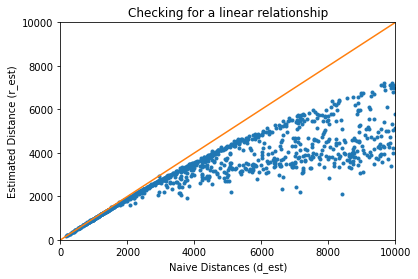

In [ ]:
plt.plot(D,rEst,'.')

plt.xlabel('Naive Distances (d_est)')
plt.ylabel('Estimated Distance (r_est)')

plt.title('Checking for a linear relationship')

plt.xlim(0,10000)
plt.ylim(0,10000)
plt.plot([0,10000],[0,10000]) # just draws the line to show if there is a 1:1 relationship

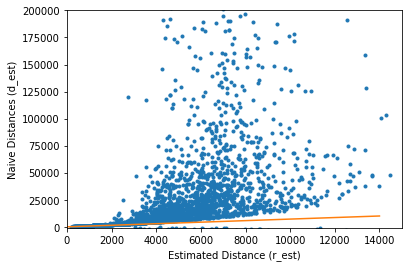

In [ ]:
plt.plot(rEst, D, '.')

plt.xlabel('Estimated Distance (r_est)')
plt.ylabel('Naive Distances (d_est)')
plt.xlim(0,15000)
plt.ylim(-1000,200000)
plt.plot([0,14000],[0,10000]) # just draws the line to show if there is a 1:1 relationship

SNR is low, relationship falls off at really large distances.

Since we will be comparing the results of our Leavitt Law using both the naive and Bailer-Jones distance estimates, you will need to remove rows with non-sensical inverse parallax distance estimates (e.g., negative parallax measurements).

make a cleanCepData mask

In [ ]:
cepData['parallax']

0       0.029784
1       0.079756
2       0.179978
3       0.608229
4       0.428942
          ...   
9563   -0.062679
9564   -0.040200
9566    0.189543
9567   -0.034575
9568    0.252304
Name: parallax, Length: 4504, dtype: float64

Create a mask to remove the negative parallax:

In [ ]:
negMask = cepData['parallax']<0
cleanCepData= cepData[~negMask]
cleanCepData.shape

(2464, 26)

# 4. Determine the *Wesenheit* magnitudes for the Classical Cepheids.



Rather than attempting to determine the individual corrections required to measure luminosities for the Cepheids in the sample, we will be calibrating the so-called *Period-Wesenheit* relation. To do this, we need to first determine the *Wesenheit* magnitude, which provides a first-order correction for the effects of dust reddening in the Gaia G-band (see [here](https://ned.ipac.caltech.edu/level5/Cepheids/Cepheids14.html) for more information). The Wesenheit magnitude is defined in [Ripepi et al. (2018)](https://ui.adsabs.harvard.edu/abs/2019A%26A...625A..14R/abstract) as:

$$ W(G, BP, RP) = G - 1.9*(BP-RP) $$

where $G, BP, {\rm and} RP$ are the Gaia magnitudes, and the factor of 1.9 is determined by using Gaia photometry derived from synthetic star templates with effective temperatures and metallicities similar to that expected for Classical Cephieds. This can be used to determine the ratio of extinction ($A_G$) to reddening ($E(BP-RP)$).

In the cell below, determine $W( G, BP, RP)$ for your sample, and also propagate the errors using the errors associated with $G, BP, {\rm and\,} RP$.


Looking at the columns to match them with the above information in the text

In [ ]:
cleanCepData.head()

,source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,ra,dec,l,...,pf_error,int_average_bp,int_average_bp_error,int_average_g,int_average_g_error,int_average_rp,int_average_rp_error,num_clean_epochs_g,distance,distance_error
0,4052922352453886976,10053.713376,7757.045820,13433.287852,2033.675494,1,1,275.945268,-25.672356,7.001862,...,0.000829,15.422571,0.003206,14.559613,0.000121,13.630170,0.003486,19,33574.992149,41795.282690
1,4103564728516764032,7524.096688,5939.009081,9900.642710,1810.259735,1,1,280.454570,-14.505427,18.916709,...,0.000204,14.575795,0.003055,13.647923,0.002157,12.940319,0.001979,17,12538.297713,6065.319448
2,4102332175955773568,4614.365023,3547.219238,6390.505312,1889.453036,1,1,284.202140,-13.622576,21.343833,...,0.000340,16.816808,0.018745,16.260889,0.000530,15.518061,0.010214,18,5556.226754,1900.971872
3,4103813802261866496,1584.494997,1443.906220,1754.713873,1784.169454,1,1,280.344007,-13.841397,19.461784,...,0.000056,10.297049,0.000359,9.721283,0.000280,9.025764,0.000337,13,1644.117886,159.225044
4,4103989346187406464,2201.676060,1958.923325,2510.741533,1568.626074,1,1,276.806044,-15.117989,16.752307,...,0.000043,10.940114,0.000439,10.069065,0.000194,9.178810,0.000208,18,2331.318090,290.152094


making some variables instead of having to constantly access the DF:

In [ ]:
g= cleanCepData['int_average_g']
#print(g)
gErr = cleanCepData['int_average_g_error']
#print(gErr)

bp= cleanCepData['int_average_bp']
#print(bp)
bpErr= cleanCepData['int_average_bp_error']
#print(bpErr)

rp=  cleanCepData['int_average_rp']
#print(rp)
rpErr = cleanCepData['int_average_rp_error']
#print(rpErr)


We Also have to reset the variable D as that will have data from cepData rather than cleanCepData

In [ ]:
D=cleanCepData['distance']
sigD= cleanCepData['distance_error']

Creating functions to determine the wesenheit magnitude and it's error using the formula above.

In [ ]:
def wesMagFn(g,bp,rp):
    wesMagFn= g - 1.9*(bp - rp)
    return wesMagFn

def wesMagErrFn(gErr,bpErr,rpErr):
    wesMagErrFn= np.sqrt((gErr)**2 +(1.9*bpErr)**2 +(1.9*rpErr)**2 )
    return wesMagErrFn

Calling the function with the values from the DF so that we can have a new variable with the magnitude `wesMag`

In [ ]:
wesMag= wesMagFn(g, bp, rp)

wesMagErr= wesMagErrFn(gErr, bpErr, rpErr)
print(wesMagErr)

0       0.008999
1       0.007245
2       0.040563
3       0.000976
4       0.000943
          ...   
9555    0.005181
9556    0.010721
9562    0.019857
9566    0.000849
9568    0.002845
Length: 2464, dtype: float64


Let's check if the mags in the DF make sense (larger mag = dimmer)

In [ ]:
wesMag

0       11.154051
1       10.540520
2       13.793270
3        7.305843
4        6.722587
          ...    
9555    14.239365
9556    16.025534
9562    15.663981
9566     5.184938
9568    13.660089
Length: 2464, dtype: float64

Above magnitudes make sense, they are values we expect to see roughly.

We should begin comparing how the magnitudes vary as we produce the Wesenheit magnitude by considering the different magnitudes

Using a histogram-style plot, compare the distribution of the $W$ magnitude to the $G, BP, {\rm and\,} RP$ bands. Do your $W$ values  make sense?

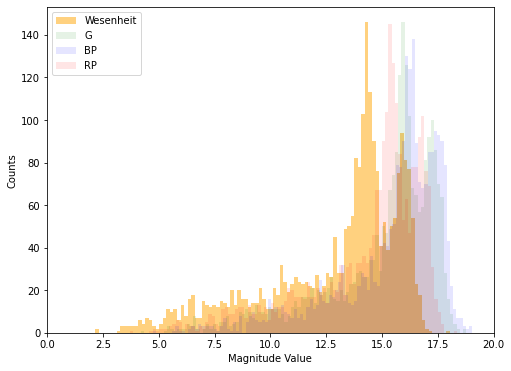

In [ ]:
# Plotting histograms for the Wesenheit magnitudes along with the magnitudes from the G-, BP- and RP-bands.
plt.figure(figsize=(8,6))

plt.hist(wesMag,bins=100,alpha=0.5,label='Wesenheit',color='orange') # Giving the Wesenheit magnitude histogram less transparency (alpha=0.5).
plt.hist(cleanCepData.int_average_g,bins=100,alpha=0.1,label='G',color='green')
plt.hist(cleanCepData.int_average_bp,bins=100,alpha=0.1,label='BP',color='blue')
plt.hist(cleanCepData.int_average_rp,bins=100,alpha=0.1,label='RP',color='red')

# Assigning the relevant label axes and concentrating on the main features of the histogram:
plt.xlabel('Magnitude Value')
plt.ylabel('Counts')
plt.xlim(0,20.0)
plt.legend(loc = 2)

Checking the shapes of the histograms, they are similar in shape. The data set is supposed to contain cepheid variable stars which we expected to show only one peak in this histogram, though we have two. This may be due to the dataset containing other objects.

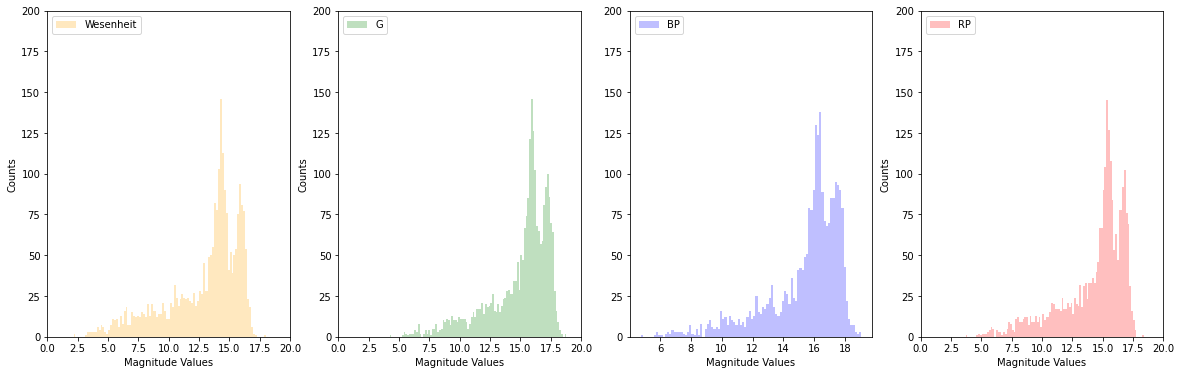

In [ ]:
# Separating the histograms into their own subplot:
plt.figure(figsize=(20, 6))

plt.subplot(1,4,1)
plt.hist(wesMag ,alpha=0.25,bins=100,label='Wesenheit',color='orange')
plt.xlabel("Magnitude Values")
plt.ylabel("Counts")
plt.xlim(0,20.0)
plt.ylim(0,200)
plt.legend(loc = 2)

plt.subplot(1,4,2)
plt.hist(cleanCepData.int_average_g,alpha=0.25,bins=100,label='G',color='green')
plt.xlabel("Magnitude Values")
plt.ylabel("Counts")
plt.xlim(0,20.0)
plt.ylim(0,200)
plt.legend(loc = 2)

plt.subplot(1,4,3)
plt.hist(cleanCepData.int_average_bp,alpha=0.25,bins=100,label='BP',color='blue')
plt.xlabel("Magnitude Values")

plt.ylim(0,200)
plt.legend(loc = 2)

plt.subplot(1,4,4)
plt.hist(cleanCepData.int_average_rp,alpha=0.25,bins=100,label='RP',color='red')
plt.xlabel("Magnitude Values")
plt.ylabel("Counts")
plt.xlim(0,20.0)
plt.ylim(0,200)
plt.legend(loc = 2)

Now, use both the naive and Bailer-Jones distance estimates to determine the absolute Wesenheit magnitudes, $M_W$. Again, be sure to propagate the uncertainties. Add both columns to your dataframe. Compare the two distributions using a histogram plot.


***The partial derivatives for the standard error propagation are:***

$\frac{\partial M}{\partial m} = 1$

$\frac{\partial M}{\partial d} = \frac{5}{d \times ln(10)}$

***Then, the standard error propagation for the absolute magnitudes is given by:***

$$\sigma_{M} = \sqrt{(\frac{\partial M}{\partial m})^2 (\sigma_{m})^2 + (\frac{\partial M}{\partial d} )^2 (\sigma_{d})^2} $$

In [ ]:
cleanCepData.columns

Index(['source_id', 'r_est', 'r_lo', 'r_hi', 'r_len', 'result_flag',
       'modality_flag', 'ra', 'dec', 'l', 'b', 'parallax', 'parallax_error',
       'type_best_classification', 'mode_best_classification', 'pf',
       'pf_error', 'int_average_bp', 'int_average_bp_error', 'int_average_g',
       'int_average_g_error', 'int_average_rp', 'int_average_rp_error',
       'num_clean_epochs_g', 'distance', 'distance_error'],
      dtype='object')

Determining the wesMag, error, using the naive distances, distance estimate r_est and the appWesMag. The Bailer-Jones distance estimate, r_est, requires the average of the deviations from r_est.

In [ ]:
# Calculating the absolute Wesenheit magnitudes using the naive distance values and Wesenheit magnitudes:
wesenheitAbsMag_d = wesMag + 5 - (5 * np.log10(cleanCepData.distance))

# Calculating the error propagation for the absolute Wesenheit magnitudes using the naive distances:
wesenheitAbsMag_d_error = ( ((1)**2 * (wesMagErr)**2) + ((5 / (cleanCepData.distance * np.log(10)))**2 * (cleanCepData.distance_error)**2) )**0.5 # sigM

# Adding the values calculated with the naive distances into new columns in the data frame:
cleanCepData['WesenheitAbsMag_Naive'] = wesenheitAbsMag_d
cleanCepData['WesenheitAbsMag_Naive_error'] = wesenheitAbsMag_d_error

# Calculating the absolute Wesenheit magnitudes using the distance estimates 'r_est' and Wesenheit magnitudes:
wesenheitAbsMag_r = wesMag + 5 - (5 * np.log10(cleanCepData.r_est))

# For the error for the Bailer-Jones distances, we need to take the average of (r_hi - r_est) and (r_est - r_lo):
r_high_deviation = cleanCepData.r_hi - cleanCepData.r_est
r_low_deviation = cleanCepData.r_est - cleanCepData.r_lo

r_deviations = {'r_high': r_high_deviation, 'r_low': r_low_deviation} # Assembling the deviation values in a way that they can be formatted into a data frame.
r_deviations_DF = pd.DataFrame(data = r_deviations) # Creating a data frame with these distance deviations.
r_deviations_DF['Mean'] = r_deviations_DF.mean(axis=1) # Taking the average of the distance deviations as the standard error for 'r_est'.

# Calculating the error propagation for the absolute Wesenheit magnitudes using the distance estimates:
wesenheitAbsMag_r_error = ( ((1)**2 * (wesMagErr)**2) + ((5 / (cleanCepData.r_est * np.log(10)))**2 * (r_deviations_DF.Mean)**2) )**0.5

# Adding the values calculated with 'r_est' into new columns in the data frame:
cleanCepData['WesenheitAbsMag_bjDist'] = wesenheitAbsMag_r
cleanCepData['WesenheitAbsMag_bjDist_error'] = wesenheitAbsMag_r_error

cleanCepData

<ipython-input-38-06a3a16d6973>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanCepData['WesenheitAbsMag_Naive'] = wesenheitAbsMag_d
<ipython-input-38-06a3a16d6973>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanCepData['WesenheitAbsMag_Naive_error'] = wesenheitAbsMag_d_error
<ipython-input-38-06a3a16d6973>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,ra,dec,l,...,int_average_g_error,int_average_rp,int_average_rp_error,num_clean_epochs_g,distance,distance_error,WesenheitAbsMag_Naive,WesenheitAbsMag_Naive_error,WesenheitAbsMag_bjDist,WesenheitAbsMag_bjDist_error
0,4052922352453886976,10053.713376,7757.045820,13433.287852,2033.675494,1,1,275.945268,-25.672356,7.001862,...,0.000121,13.630170,0.003486,19,33574.992149,41795.282690,-6.476029,2.703137,-3.857582,0.613064
1,4103564728516764032,7524.096688,5939.009081,9900.642710,1810.259735,1,1,280.454570,-14.505427,18.916709,...,0.002157,12.940319,0.001979,17,12538.297713,6065.319448,-4.950673,1.050461,-3.841752,0.571714
2,4102332175955773568,4614.365023,3547.219238,6390.505312,1889.453036,1,1,284.202140,-13.622576,21.343833,...,0.000530,15.518061,0.010214,18,5556.226754,1900.971872,0.069370,0.744040,0.472710,0.670239
3,4103813802261866496,1584.494997,1443.906220,1754.713873,1784.169454,1,1,280.344007,-13.841397,19.461784,...,0.000280,9.025764,0.000337,13,1644.117886,159.225044,-3.773822,0.210299,-3.693612,0.212976
4,4103989346187406464,2201.676060,1958.923325,2510.741533,1568.626074,1,1,276.806044,-15.117989,16.752307,...,0.000194,9.178810,0.000208,18,2331.318090,290.152094,-5.115420,0.270260,-4.991180,0.272126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9555,4687502056776727552,7128.694189,6078.544227,8447.877816,575.140884,1,1,16.354050,-72.247545,301.430010,...,0.000238,15.251309,0.001807,30,39103.646399,52002.832057,-3.721721,2.887784,-0.025685,0.360899
9556,4687502503453207552,4440.111514,3583.190978,5595.473399,574.009256,1,1,16.638514,-72.202889,301.302874,...,0.000976,16.427778,0.003789,26,20563.921584,32193.474660,-0.539996,3.399526,2.788564,0.492178
9562,4687576445579527808,4613.318214,3768.590955,5736.519497,563.329426,1,1,19.410230,-71.763089,300.026776,...,0.000584,16.448485,0.009054,29,19234.137845,25510.655941,-0.756382,2.880140,2.343914,0.463574
9566,5864135319959353600,4489.321528,3850.622703,5359.322671,1638.294878,1,1,204.153660,-64.558316,307.761442,...,0.000248,8.118965,0.000167,38,5275.843158,990.436468,-8.426521,0.407652,-8.075965,0.364878


Plotting the results

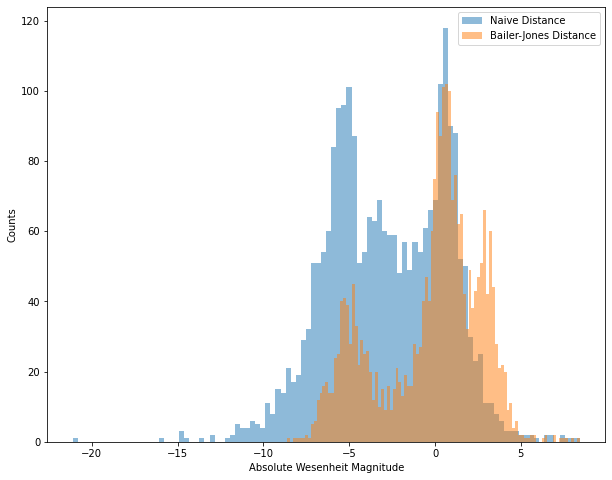

In [ ]:
# Plotting the distribution of absolute Wesenheit magnitudes calculated with the two distance measurements:
plt.figure(figsize=(10,8))
plt.hist(wesenheitAbsMag_d,alpha=0.5,bins=100,label="Naive Distance")
plt.hist(wesenheitAbsMag_r,alpha=0.5,bins=100,label="Bailer-Jones Distance")

# Giving appropriate label names and legend:
plt.xlabel("Absolute Wesenheit Magnitude")
plt.ylabel("Counts")
plt.legend()

Bailer Jones and Naive estimates diverge for larger distances (>1000pc) due to Bailer-Jones estimates use prior knowledge of the distribution of stars in the Galaxy in the distance estimates. When the uncertainties are large compared to the measured value (i.e. for large distances), this prior dominates the measurement, giving more reasonable distance estimates (i.e. not >$10^4$pc)

# 5. Plotting the Wesenheit magnitude, $M_W$, Period Relation (PWR).


Plot a scatter plot of $M_W$ versus $log_{10} P$, where $P$ is the period in days for both distance estimates. Be sure to get your y-axis right -- brightness should increase towards the top of the diagram.

Describe what you see in the plots. Does it make sense? How does the PWR compare for the two distance estimates?

Try filtering your catalogue to exclude those objects with parallax-to-parallax-error ratios < 5. You can try other values, too. Describe the changes.


Calling the pf column as that is the period corresponding to the fundamental pulsation mode. Also we're making the periods in $\log_{10}$  so the scales of the plot are more easily read.

Since we want to see the plot with increasing brightness, rather than increasing magnitude value, we need to invert the magnitudes:

-----------

Plotting the Wesenheit magnitude as a function of period

In [ ]:
cleanCepData.columns

Index(['source_id', 'r_est', 'r_lo', 'r_hi', 'r_len', 'result_flag',
       'modality_flag', 'ra', 'dec', 'l', 'b', 'parallax', 'parallax_error',
       'type_best_classification', 'mode_best_classification', 'pf',
       'pf_error', 'int_average_bp', 'int_average_bp_error', 'int_average_g',
       'int_average_g_error', 'int_average_rp', 'int_average_rp_error',
       'num_clean_epochs_g', 'distance', 'distance_error',
       'WesenheitAbsMag_Naive', 'WesenheitAbsMag_Naive_error',
       'WesenheitAbsMag_bjDist', 'WesenheitAbsMag_bjDist_error'],
      dtype='object')

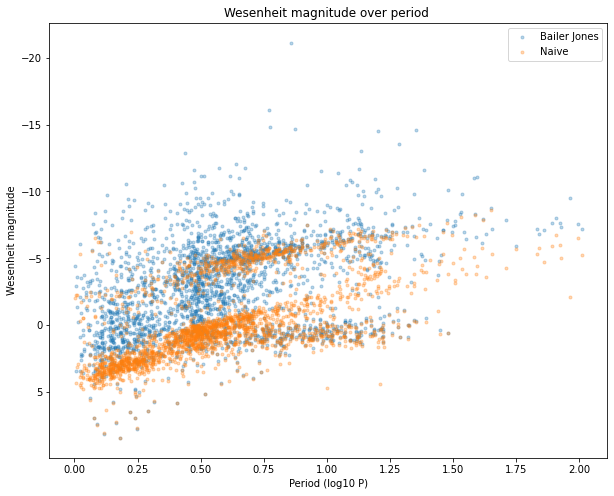

In [ ]:
pf= np.log10(cleanCepData['pf'])
#to convert to seconds:
#P= np.log10(cleanCepData['pf']**24*3600)
pfErr=np.log10(cleanCepData['pf_error'])

plt.figure(figsize=(10,8))
plt.scatter(pf,cleanCepData['WesenheitAbsMag_Naive'],marker='.',label='Bailer Jones',alpha=0.3)
plt.scatter(pf,cleanCepData['WesenheitAbsMag_bjDist'],marker='.',label='Naive',alpha=0.3)

plt.xlabel('Period (log10 P)')
plt.ylabel('Wesenheit magnitude')
plt.gca().invert_yaxis() # we want to see the increase in brightness, so we flip the y axis to reflect this.
plt.title('Wesenheit magnitude over period ')
plt.legend()


Creating a parallax to parallax error ratio <5 and converting to log scale for the period

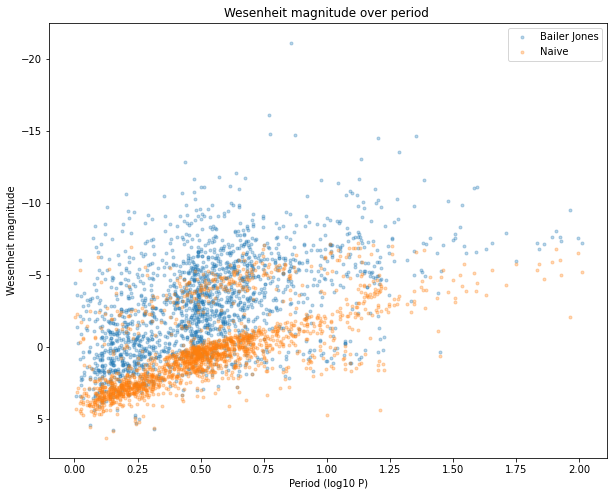

In [ ]:
parallax= cleanCepData['parallax']
parallax_error= cleanCepData['parallax_error']

parallaxMask= parallax/parallax_error <5

CepData5= cleanCepData[parallaxMask]

pf= np.log10(CepData5['pf'])
#to convert to seconds:
#P= np.log10(cleanCepData['pf']**24*3600)
pfErr=np.log10(CepData5['pf_error'])

plt.figure(figsize=(10,8))
plt.scatter(pf,CepData5['WesenheitAbsMag_Naive'],marker='.',label='Bailer Jones',alpha=0.3)
plt.scatter(pf,CepData5['WesenheitAbsMag_bjDist'],marker='.',label='Naive',alpha=0.3)

plt.xlabel('Period (log10 P)')
plt.ylabel('Wesenheit magnitude')
plt.gca().invert_yaxis() # we want to see the increase in brightness, so we flip the y axis to reflect this.
plt.title('Wesenheit magnitude over period ')
plt.legend()


- No error bars are included. Will possibly be too small to include. We want to show with the plot that we're comparing the two magnitudes. If we were looking at a single magnitude we would probably include the error bars then. Although Matt did include error bars in his plot.

- We can see the spread of the points are different between the two distance measurements. Bailer Jones almost shows a linear relationship and the Naive points are more spread out.

- For both distance measurements, we can see two distinct groupings of points.

---------

TASK: Explore your data -- are the results as expected? Make any further cuts required to refine the selection (we may need to discuss!).


----



We also need to consider additional cuts. Whether the cepheids are in the disk or halo/ out of the disk. Though note we're using `cleanCepData` instead of `cepData5` as we will need to do different parallax ratios later on.

To do this, we need to look at stars in the galactic longtitude range of -2 to 2. So let's make a mask:

The above mask did not work correctly in dropping the rows so let's do it another way

In [ ]:
# Making a deep copy of the data frame:
gaiaDFClean_DCEP_PWR = cleanCepData.copy(deep=True)

# Removing sources with parallax-to-parallax-error ratios smaller than 5
gaiaDFClean_DCEP_PWR.drop(gaiaDFClean_DCEP_PWR[gaiaDFClean_DCEP_PWR.parallax / gaiaDFClean_DCEP_PWR.parallax_error < 5].index, inplace=True)

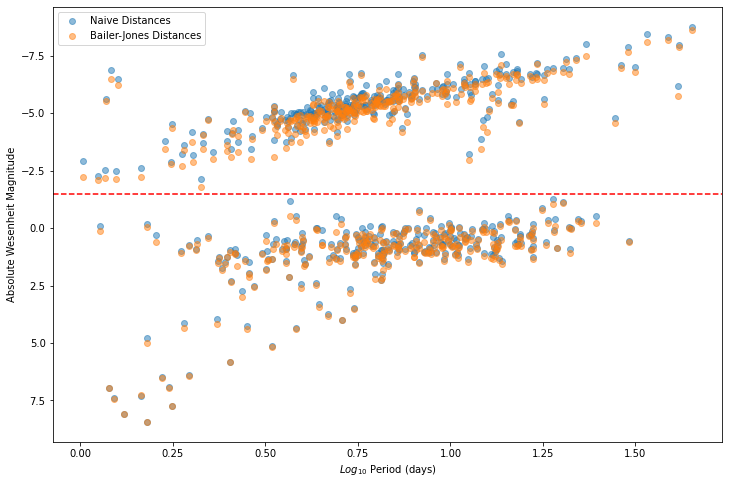

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(np.log10(gaiaDFClean_DCEP_PWR.pf),gaiaDFClean_DCEP_PWR.WesenheitAbsMag_Naive,alpha=0.5,label='Naive Distances')
plt.scatter(np.log10(gaiaDFClean_DCEP_PWR.pf),gaiaDFClean_DCEP_PWR.WesenheitAbsMag_bjDist,alpha=0.5,label='Bailer-Jones Distances')

plt.axhline(y=-1.5,xmin=0,xmax=2,color='red',linestyle='--')

plt.xlabel("$Log_{10}$ Period (days)")
plt.ylabel("Absolute Wesenheit Magnitude")
plt.gca().invert_yaxis() # Invert the y-axis so that the negative values (which correspond to higher brightness) are at the top.
plt.legend()

Removing the data with parallax-to-parallax-error ratios greater than 5 yields more distinguishable groupings.

We want to check where these points lie in the galactic plane using a galactic plane between 5 and -5, we can now visualise where the points lie:

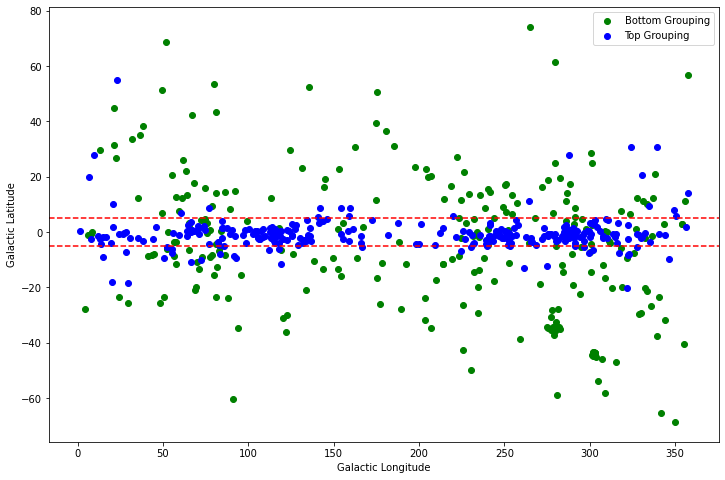

In [ ]:
# Creating two separate data frames for the top and bottom grouping of sources:
top_grouping = gaiaDFClean_DCEP_PWR[gaiaDFClean_DCEP_PWR.WesenheitAbsMag_bjDist < -1.5] # Absolute Wesenheit magnitudes brighter than -1.5.
bottom_grouping = gaiaDFClean_DCEP_PWR[gaiaDFClean_DCEP_PWR.WesenheitAbsMag_bjDist > -1.5] # Absolute Wesenheit magnitudes dimmer than -1.5.

# Plotting the galactic latitudes and galactic longitudes for each grouping:
plt.figure(figsize=(12,8))
plt.scatter(bottom_grouping.l,bottom_grouping.b,color='green',label='Bottom Grouping') # Bottom grouping of sources
plt.scatter(top_grouping.l,top_grouping.b,color='blue',label='Top Grouping') # Top grouping of sources

# Marking the region with galactic latitudes between +/- 5 degrees:
plt.axhline(y=5,xmin=0,xmax=360,color='red',linestyle='--')
plt.axhline(y=-5,xmin=0,xmax=360,color='red',linestyle='--')

# Applying appropriate label axes and legend for the data:
plt.xlabel("Galactic Longitude")
plt.ylabel("Galactic Latitude")
plt.legend()

We can now see where these groupings of stars lie in the galactic plane. One group lies predominantly within the disk (blue) and the others are in the halo. As Cepheid variable stars are young, they lie in the disk of the galaxy. The stars in the halo could have been misclassified and so we can ignore them. We set the CV to have a absolute Wesenheit magnitude brighter than -1.5 and therefore more negative.

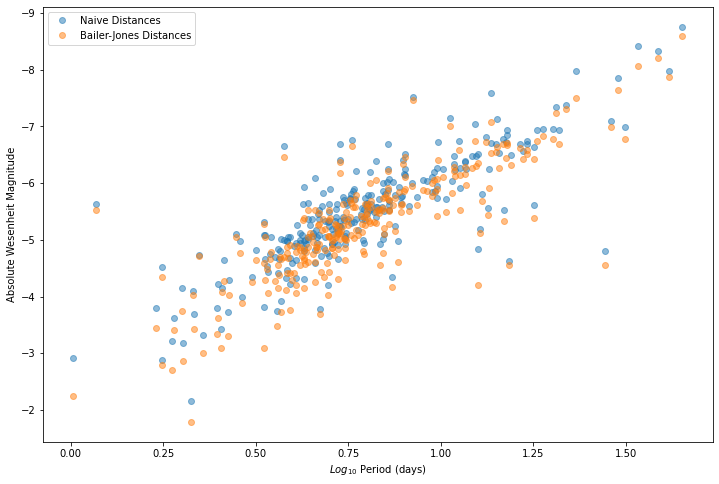

In [ ]:
gaiaDF_PWR = gaiaDFClean_DCEP_PWR[gaiaDFClean_DCEP_PWR.b < abs(5)] # Selecting sources with galactic latitudes between +/- 5 degrees.
gaiaDF_PWR = gaiaDF_PWR[gaiaDF_PWR.WesenheitAbsMag_bjDist < -1.5] # Selecting sources with absolute Wesenheit magnitudes brighter than -1.5.
gaiaDF_PWR.reset_index(drop=True, inplace=True) # The two filters will require the data frame to have its indices resetted.

# Plotting the filtered data done above:
plt.figure(figsize=(12,8))
plt.plot(np.log10(gaiaDF_PWR.pf),gaiaDF_PWR.WesenheitAbsMag_Naive,'o',alpha=0.5,label='Naive Distances')
plt.plot(np.log10(gaiaDF_PWR.pf),gaiaDF_PWR.WesenheitAbsMag_bjDist,'o',alpha=0.5,label='Bailer-Jones Distances')

# Applying appropriate label axes and legend for the data points:
plt.xlabel("$Log_{10}$ Period (days)")
plt.ylabel("Absolute Wesenheit Magnitude")
plt.gca().invert_yaxis() # Invert the y-axis so that the negative values (which correspond to higher brightness) are at the top.
plt.legend()

After applying the galactic plane filter, the groupings of stars has decreased to one. We can see a linear relationship and the two distance measurements have similar values now.

# 6. Fitting a straight line to the PWR


With our filtered catalogue in hand, we are now in a position to fit the PWR using a straight-line model (i.e., polynomial with order 1). To do this, we will first use standard optimisation, and then we will use MCMC, which explores the parameter space more thoroughly and provides best fit estimates for the parameters and their associated uncertainties.

To begin, you need to write a function that returns a straight line given a set of parametrers, $p$, and an $x$-coordinate. You can look back at the Lectorial notebooks for inspiration!

Be sure to test your function by generating fake x-values, and plotting the results for a set of parameters.

--------------------------------------------------

We're just making a 1d polynomial, in other words, the formula for a straight line.

We now want to fit a line to our filtered data. We can do so with the `np.polyfit()` and `np.polyfit1d()` functions.

In [ ]:
def poly1Dfit(xData, yData, label):

  line_fit = np.polyfit(xData, yData, deg=1) # Determining a fit of order 1 (linear) to the x- (xData) and y-values (yData).
  poly_sol = np.poly1d(line_fit)

  print(f"The coefficients of the linear fit are: [{poly_sol[0]}, {poly_sol[1]}].") # Showing the coefficients of the linear fit.

  x_vector = np.linspace(0,2,100) # Generating a vector of x-values to plot the linear fit.
  plt.plot(x_vector,poly_sol(x_vector),linestyle='-',label=label)

  return poly_sol

The coefficients of the linear fit are: [-3.1263266224950397, -2.9807322802678047].
The coefficients of the linear fit are: [-2.8348227026499817, -3.077825669125079].


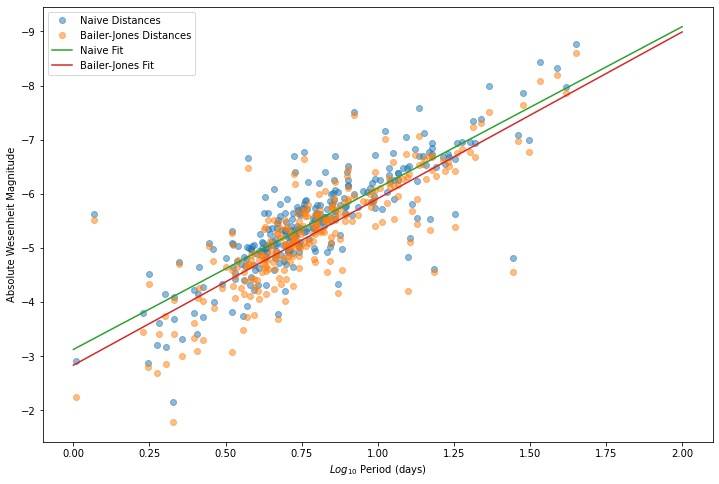

In [ ]:
# Plotting the logarithm of the periods with the associated absolute Wesenheit magnitudes for each distance measurement:
plt.figure(figsize=(12,8))
plt.plot(np.log10(gaiaDF_PWR.pf),gaiaDF_PWR.WesenheitAbsMag_Naive,'o',alpha=0.5,label='Naive Distances')
plt.plot(np.log10(gaiaDF_PWR.pf),gaiaDF_PWR.WesenheitAbsMag_bjDist,'o',alpha=0.5,label='Bailer-Jones Distances')

# Using the above function to find a linear fit for the data:
naiveFit= poly1Dfit(np.log10(gaiaDF_PWR.pf),gaiaDF_PWR.WesenheitAbsMag_Naive,label='Naive Fit')
naiveFit
bjFit= poly1Dfit(np.log10(gaiaDF_PWR.pf),gaiaDF_PWR.WesenheitAbsMag_bjDist,label='Bailer-Jones Fit')
bjFit

# Applying appropriate label axes and legend for the data:
plt.xlabel("$Log_{10}$ Period (days)")
plt.ylabel("Absolute Wesenheit Magnitude")
plt.gca().invert_yaxis() # Invert the y-axis so that the negative values (which correspond to higher brightness) are at the top.
plt.legend()


The functions have fit the data sets well. We can see the similarities in the two distance measurements now using the fitted line.

In [ ]:
# Defining variables for the parameters of the linear fit above:
# [y-intercept, gradient]
p0_naive = [naiveFit[0], naiveFit[1]]# Coefficients of the linear fit for the naive distances.
p0_bj = [bjFit[0], bjFit[0]] # Coefficients of the linear fit for the Bailer-Jones distances.

Now, define a function that returns the $\chi^2$ for a given set of parameters, $p$, and data points $x, y$ and the uncertainty associated with the $y-$values, $\sigma_y$. We will assume that the uncertainties on the $x-$values are very small, and can therefore be ignored.

The $\chi^2$ value of a fit can be calculated using:

$$\chi^2 = \sum_{i=1}^n~\left(\frac{y_{i,~{\rm data}} - y_{i,~{\rm model}}}{\sigma_{y,~i}}\right)^2$$

***Using functions adapted from the lectorials:***

In [ ]:
# This function creates a polynomial based on the input coefficients:
def polyN(p):
  def rfunc(x):
    y = 0
    # For each coefficient in 'p', assign it a power of 'x' depending on the index of that coefficient in 'p'.
    for i in np.arange(len(p)):
      y += p[i]*x**float(i)
    return y
  return rfunc

In [ ]:
# Defining a function that calculates the chi-squared value of the fit given the fitting parameters 'p' and the data.
def chisq(p, xData, yData, yerrData):
  poly_func = polyN(p)

  yFit = poly_func(xData) # Calculating the predicted values for the data points with the linear fit.

  chiSqValue = np.sum( ((yData - yFit)/yerrData)**2 )

  return chiSqValue

In [ ]:
# Calculating the chi-squared values of the linear fits calculated above:
chisq_naive = chisq(p0_naive,np.log10(gaiaDF_PWR.pf), gaiaDF_PWR.WesenheitAbsMag_Naive, gaiaDF_PWR.WesenheitAbsMag_Naive_error)
chisq_bj = chisq(p0_bj,np.log10(gaiaDF_PWR.pf), gaiaDF_PWR.WesenheitAbsMag_bjDist, gaiaDF_PWR.WesenheitAbsMag_bjDist_error)

print(f"The chi-squared value of the linear fit for the naive distances is: {chisq_naive}, and Bailer-Jones distances is: {chisq_bj}.")

The chi-squared value of the linear fit for the naive distances is: 1564.296018741898.
The chi-squared value of the linear fit for the Bailer-Jones distances is: 2785.4512777214477.


We are now ready to fit the data. Use `fmin` from *scipy.optimize* to run a simple fit to both PWRs. Don't forget to determine initial estimates for your parameters -- these are required as input to the optimiser.

Run fits for several different cuts in parallax-to-parallax-error ratios. Compare your results using plots and quantitative assessment. One way to quantitatively compare the fidelity of the PWR for the naive and Bailer-Jones distance estimates is to examine the residuals in the $y-$data after subtracting the best-fitting model predicted for the $x-$value. You can plot the histogram of the residuals, which should resemble a Gaussian distribution. You can determine the median and spread (using numpy percentiles, or the mean and standard deviation) for the distribution in order to understand if there is a lower overall scatter for a given distance estimate. How do these values change with changing parallax-to-parallax-error ratios?

Based on your results, choose a sensible value to filter our catalogue based on the results for different parallax-to-parallax-error values.

To reduce repetitiveness of code, we can define a function that will perform the following requirements:

* Determining the best linear fit for the data (both distance measurements) with different parallax-to-parallax-error ratios by minimising $\chi^2$ (part 1 of the function)

* Plotting this optimised linear fit with the data (part 2 of the function)

* Showing the residuals of the optimised fit with a histogram to see the distribution of residuals and indication of whether it is a good fit (part 3 of the function)

In [ ]:
import scipy.optimize as op

In [ ]:
def optimisedFit(dataframe, p2perr, p0Naive, p0BJ):
  """
  A function used to return two plots of the data ('dataframe') depending on the parallax-to-parallax-error ratio 'p2perr' and values associated with the plots.
  First plot shows the optimised linear fit of the data given initial coefficient estimates for the fit ('p0Naive' and 'p0BJ').
  Second plot shows the residuals of the optimised fit in a histogram.
  """

  # Creating a deep copy of the data frame:
  df = dataframe.copy(deep=True)

  #---------------- Part 1 ----------------------

  # Filtering out sources with parallax-to-parallax-error ratios < 'p2perr'.
  df.drop(df[df.parallax / df.parallax_error < p2perr].index, inplace=True)

  # Running the optimising function for the data with naive and Bailer-Jones distances, then printing the optimised fitting parameters:
  optValues_Naive = op.fmin(chisq, p0Naive, args=(np.log10(df.pf), df.WesenheitAbsMag_Naive, df.WesenheitAbsMag_Naive_error), full_output=1, disp=1)
  optValues_BJ = op.fmin(chisq, p0BJ, args=(np.log10(df.pf), df.WesenheitAbsMag_bjDist, df.WesenheitAbsMag_bjDist_error), full_output=1, disp=1)
  print(f"Optimised Parameters for Naive Fit: {optValues_Naive[0]} | Optimised ChiSq Value: {optValues_Naive[1]}")
  print(f"Optimised Parameters for BJ Fit: {optValues_BJ[0]} | Optimised ChiSq Value: {optValues_BJ[1]}")

  # Using the optimised fitting parameters calculated above to create a polynomial, which is then used to find the residuals:
  poly_func_Naive = polyN(optValues_Naive[0])
  yFit_Naive = poly_func_Naive(np.log10(df.pf)) # Predicted values using the x-values
  residuals_Naive = df.WesenheitAbsMag_Naive - yFit_Naive # Residuals calculation
  print(f"Mean of Naive Residuals: {np.mean(residuals_Naive)} | StDev of Naive Residuals: {np.std(residuals_Naive)}")

  # Repeating the same process for the Bailer-Jones distances:
  poly_func_BJ = polyN(optValues_BJ[0])
  yFit_BJ = poly_func_BJ(np.log10(df.pf))
  residuals_BJ = df.WesenheitAbsMag_bjDist - yFit_BJ
  print(f"Mean of BJ Residuals: {np.mean(residuals_BJ)} | StDev of BJ Residuals: {np.std(residuals_BJ)}")


  #---------------- Part 2 ----------------------
  # Generating two plots
  fig = plt.figure(figsize=(20,8))

  # First subplot is for the optimised linear fit for both the naive and Bailer-Jones distances, and plotting the data with them:
  plt.subplot(121)
  plt.plot(np.log10(df.pf), df.WesenheitAbsMag_Naive, 'o', alpha=0.5, label='Naive Data')
  plt.plot(np.linspace(0,2,100), poly_func_Naive(np.linspace(0,2,100)),'--', label='Naive Fit')

  plt.plot(np.log10(df.pf), df.WesenheitAbsMag_bjDist, 'o', alpha=0.5, label='BJ Data')
  plt.plot(np.linspace(0,2,100), poly_func_BJ(np.linspace(0,2,100)),'--', label=' BJ Fit')

  plt.xlabel("$Log_{10}$ Period (days)")
  plt.ylabel("Absolute Wesenheit Magnitude")
  plt.gca().invert_yaxis() # Inverting axis so more negative values mean brighter sources.
  plt.legend()

  #---------------- Part 3 ----------------------
  # Second subplot is the histogram of the residuals for the optimised linear fits:
  plt.subplot(122)
  plt.hist(residuals_Naive, bins=50, alpha=0.5)
  plt.hist(residuals_BJ, bins=50, alpha=0.5)
  plt.xlabel("Residuals")
  plt.ylabel("Counts")

***Using the function for the current data, with parallax-to-parallax-error ratios < 5 already filtered out.***

Optimization terminated successfully.
         Current function value: 1564.269044
         Iterations: 29
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 1820.718840
         Iterations: 30
         Function evaluations: 58
Optimised Parameters for Naive Fit: [-3.12075626 -2.98716827] | Optimised ChiSq Value: 1564.269043900019
Optimised Parameters for BJ Fit: [-2.96834053 -3.02603113] | Optimised ChiSq Value: 1820.718840333973
Mean of Naive Residuals: -0.00045857462577531693 | StDev of Naive Residuals: 0.5451362764524369
Mean of BJ Residuals: 0.09237995732504382 | StDev of BJ Residuals: 0.5623140639410035


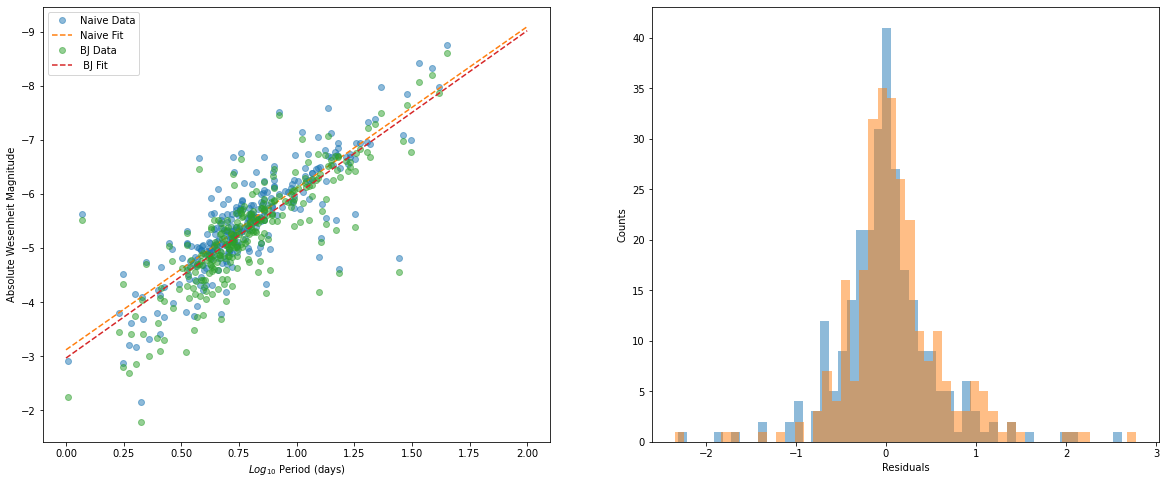

In [ ]:
optimisedFit(gaiaDF_PWR, 5, p0_naive, p0_bj)

### **Testing Other Parallax-to-Parallax-Error Ratios**

Optimization terminated successfully.
         Current function value: 1378.195392
         Iterations: 30
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 1513.143074
         Iterations: 31
         Function evaluations: 60
Optimised Parameters for Naive Fit: [-3.13178628 -2.97680308] | Optimised ChiSq Value: 1378.1953918176373
Optimised Parameters for BJ Fit: [-3.01595467 -2.98435246] | Optimised ChiSq Value: 1513.1430739403218
Mean of Naive Residuals: -0.015265697694949508 | StDev of Naive Residuals: 0.4778523591299299
Mean of BJ Residuals: 0.050605184645162934 | StDev of BJ Residuals: 0.48826692807069993


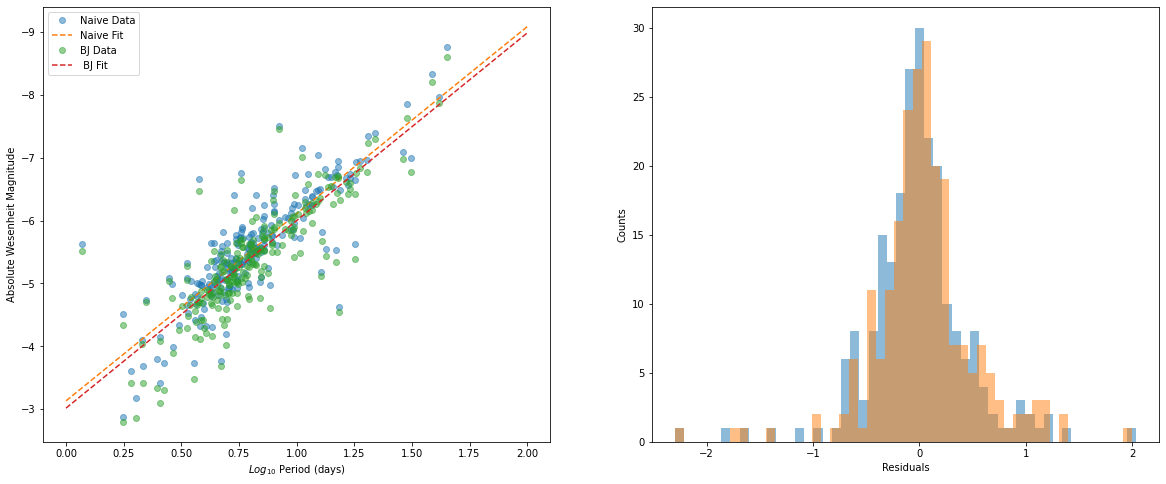

In [ ]:
optimisedFit(gaiaDF_PWR, 6, p0_naive, p0_bj)

Optimization terminated successfully.
         Current function value: 1272.332910
         Iterations: 29
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 1394.188656
         Iterations: 28
         Function evaluations: 56
Optimised Parameters for Naive Fit: [-3.12807225 -2.97394888] | Optimised ChiSq Value: 1272.3329096441455
Optimised Parameters for BJ Fit: [-3.02575145 -2.97210782] | Optimised ChiSq Value: 1394.1886558148144
Mean of Naive Residuals: 0.010208067386920512 | StDev of Naive Residuals: 0.4484721107072286
Mean of BJ Residuals: 0.06479609985028223 | StDev of BJ Residuals: 0.4570179316965854


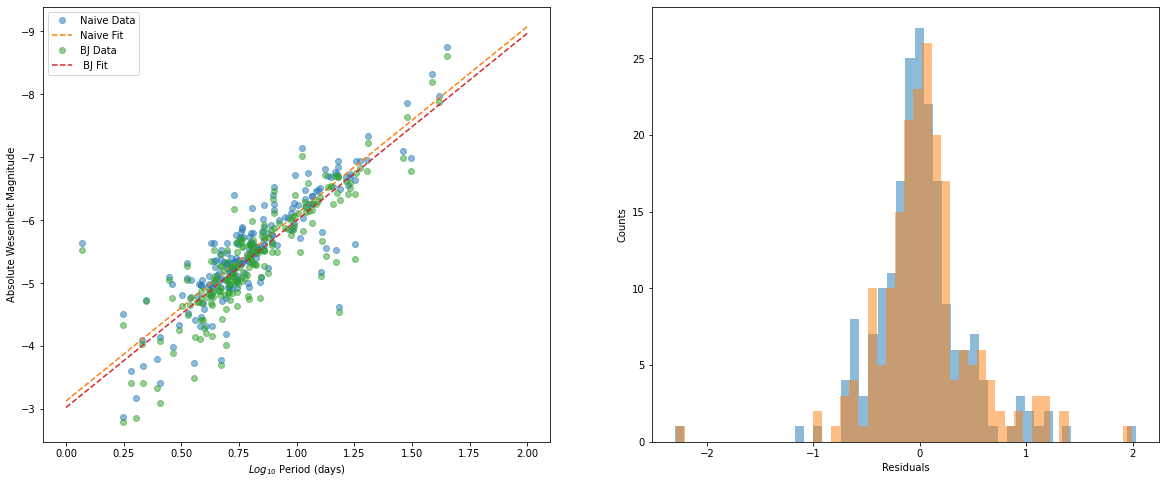

In [ ]:
optimisedFit(gaiaDF_PWR, 7, p0_naive, p0_bj)

Optimization terminated successfully.
         Current function value: 1212.621764
         Iterations: 31
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 1298.619391
         Iterations: 27
         Function evaluations: 55
Optimised Parameters for Naive Fit: [-3.14496531 -2.9565112 ] | Optimised ChiSq Value: 1212.621763676334
Optimised Parameters for BJ Fit: [-3.06337471 -2.93781474] | Optimised ChiSq Value: 1298.6193905509303
Mean of Naive Residuals: 0.001993301788183116 | StDev of Naive Residuals: 0.45238736118900874
Mean of BJ Residuals: 0.04418220275000314 | StDev of BJ Residuals: 0.45682108876271843


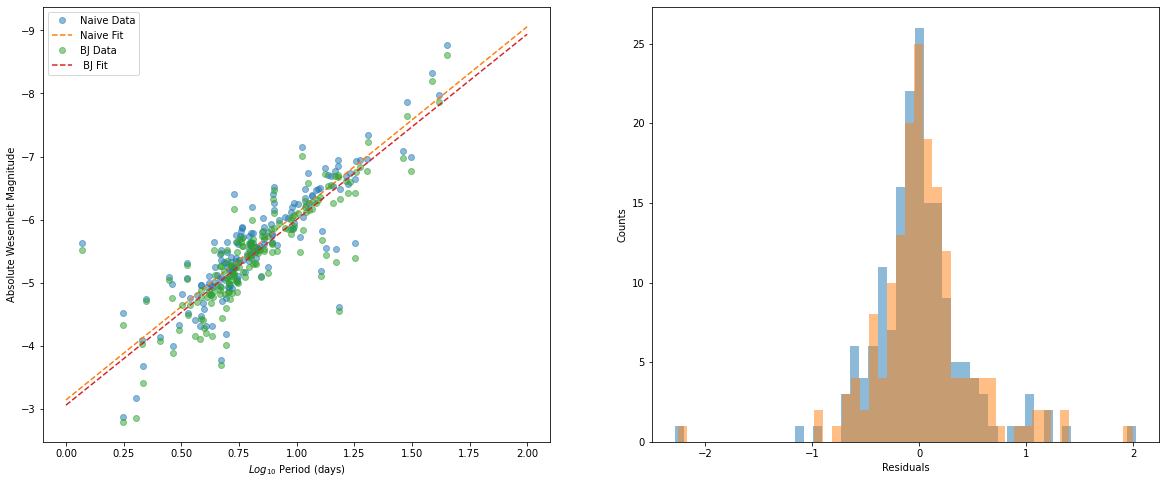

In [ ]:
optimisedFit(gaiaDF_PWR, 8, p0_naive, p0_bj)

Optimization terminated successfully.
         Current function value: 1152.476037
         Iterations: 31
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: 1208.823607
         Iterations: 30
         Function evaluations: 59
Optimised Parameters for Naive Fit: [-3.15311184 -2.95132314] | Optimised ChiSq Value: 1152.4760369678052
Optimised Parameters for BJ Fit: [-3.08338608 -2.92453608] | Optimised ChiSq Value: 1208.8236069330762
Mean of Naive Residuals: -0.00854253341812502 | StDev of Naive Residuals: 0.4523215603095843
Mean of BJ Residuals: 0.02610627790623226 | StDev of BJ Residuals: 0.45201832797407704


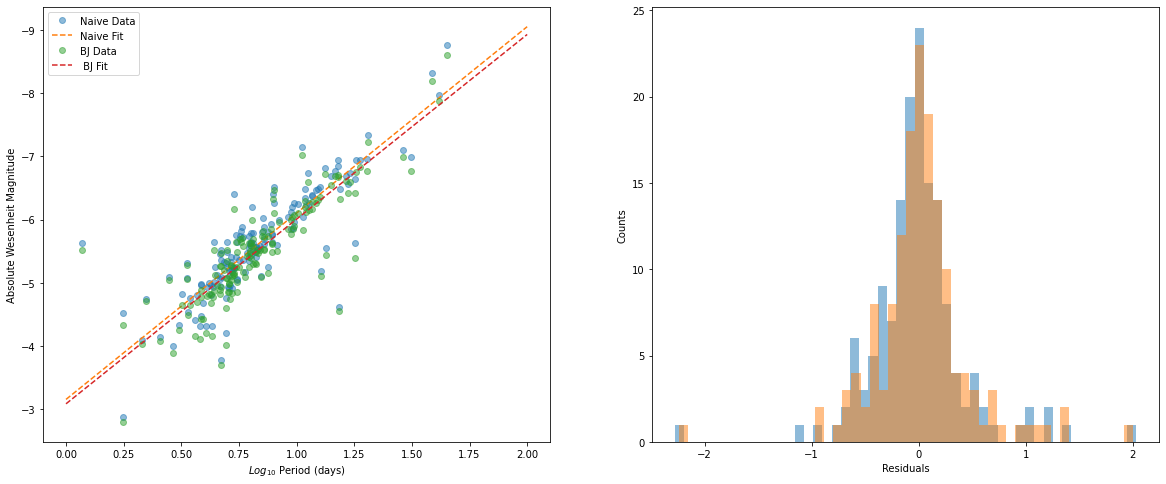

In [ ]:
optimisedFit(gaiaDF_PWR, 9, p0_naive, p0_bj)

Optimization terminated successfully.
         Current function value: 962.424990
         Iterations: 26
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 1006.507098
         Iterations: 31
         Function evaluations: 59
Optimised Parameters for Naive Fit: [-3.09070164 -3.02268095] | Optimised ChiSq Value: 962.424989703212
Optimised Parameters for BJ Fit: [-3.02861091 -2.99384591] | Optimised ChiSq Value: 1006.5070981545199
Mean of Naive Residuals: 0.006540715541214191 | StDev of Naive Residuals: 0.41223657613363934
Mean of BJ Residuals: 0.034493088889757696 | StDev of BJ Residuals: 0.41114443169920467


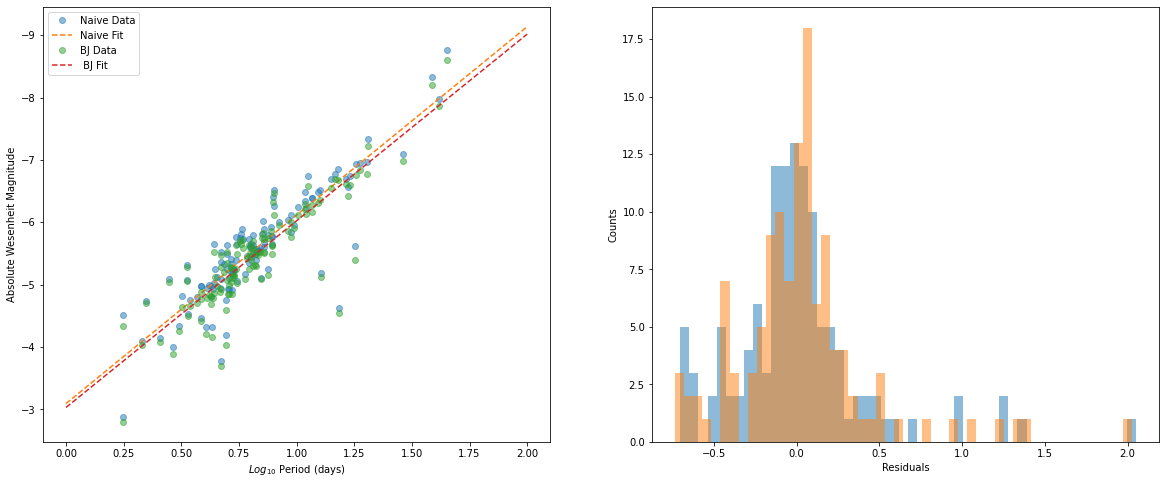

In [ ]:
optimisedFit(gaiaDF_PWR, 10, p0_naive, p0_bj)

Optimization terminated successfully.
         Current function value: 856.821379
         Iterations: 26
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 880.667872
         Iterations: 32
         Function evaluations: 61
Optimised Parameters for Naive Fit: [-3.09222964 -3.02933766] | Optimised ChiSq Value: 856.8213792809703
Optimised Parameters for BJ Fit: [-3.02427505 -3.01180938] | Optimised ChiSq Value: 880.6678720497845
Mean of Naive Residuals: -0.010915904910426431 | StDev of Naive Residuals: 0.38376525320201166
Mean of BJ Residuals: 0.013775978908734946 | StDev of BJ Residuals: 0.37918704916164386


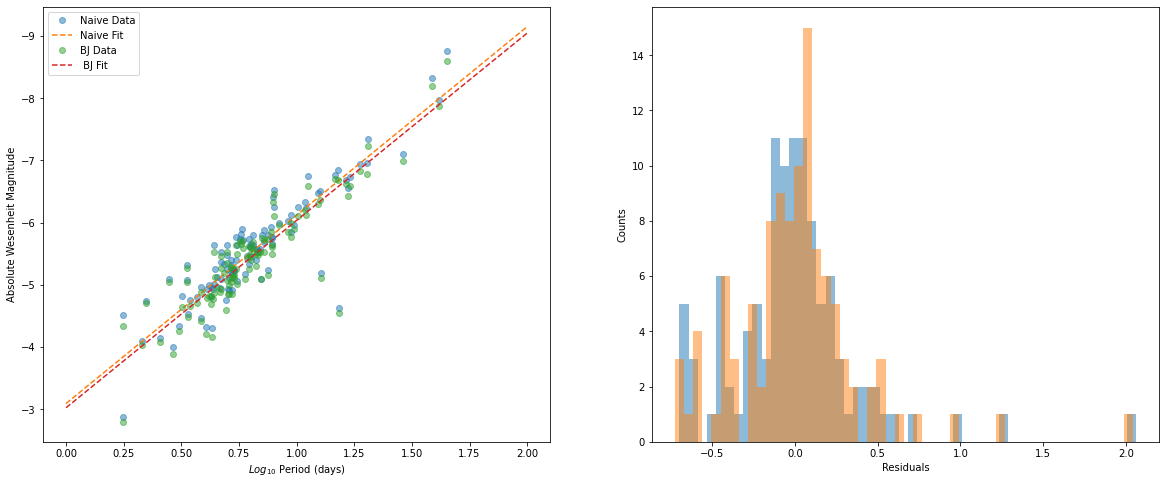

In [ ]:
optimisedFit(gaiaDF_PWR, 11, p0_naive, p0_bj)

Optimization terminated successfully.
         Current function value: 761.717089
         Iterations: 29
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: 784.734290
         Iterations: 30
         Function evaluations: 60
Optimised Parameters for Naive Fit: [-3.09211329 -3.03744424] | Optimised ChiSq Value: 761.7170887213434
Optimised Parameters for BJ Fit: [-3.02511785 -3.02171498] | Optimised ChiSq Value: 784.7342897367128
Mean of Naive Residuals: -0.024998545736206145 | StDev of Naive Residuals: 0.36491040648233153
Mean of BJ Residuals: -0.002748405131738881 | StDev of BJ Residuals: 0.3617055545161898


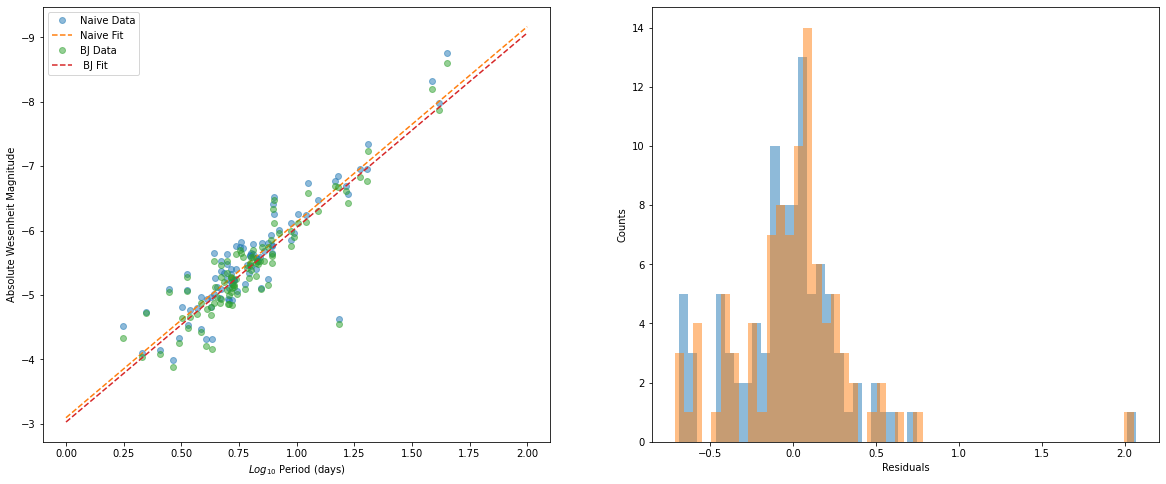

In [ ]:
optimisedFit(gaiaDF_PWR, 12, p0_naive, p0_bj)

## Section conclusion:


Applying the optimisation function to different values of parallax-to-parallax-error values to determine the best $\chi^2$ value. We also saw a reduction in the standard deviation and mean for both distance measurements. We saw an improvement in the $\chi^2$ value of approximately 43% and 53% for the Naive and Bailer-Jones fit respectively.

It is also important to note that for higher parallax-to-parallax-error values, we saw further reductions though more data was excluded from the processing.

# 7. Finalising the best fit parameters


When you plotted the residuals,  you may have noticed that there were outliers that were more than $3\sigma$ from the mean/median of the residuals. These outliers can affect the fits. There are several methods by which we can account for these outliers in order to minimise their impact on the fits. Here, we will simply filter those datapoints and refit.

Using your sample filtered for parallax-to-parallax-error (with your chosen value above), determine which of the objects are outliers (i.e., they are further than $3\sigma$ from the mean/median of the distribution of residuals), and filter those objects out of your sample. Refit both PWRs using your newly cleaned sample. Plot your results - do they appear to do a better job?

Now that we have found the optimal parallax-to-parallax-error ratio, we should separate the dataframe into two, one containing the Naive distance and one containing the Bailer-Jones distance. We want to separate them because one data point may be related to one distance method and not the other; having one dataframe will cause us to lose this dataframe.

Calling the function for parallax-to-parallax-error <10

Optimization terminated successfully.
         Current function value: 962.424990
         Iterations: 26
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 1006.507099
         Iterations: 29
         Function evaluations: 56
Optimised Parameters for Naive Fit: [-3.09070164 -3.02268095] | Optimised ChiSq Value: 962.424989703212
Optimised Parameters for BJ Fit: [-3.02862594 -2.99382086] | Optimised ChiSq Value: 1006.5070985788838
Mean of Naive Residuals: 0.006540715541214191 | StDev of Naive Residuals: 0.41223657613363934
Mean of BJ Residuals: 0.0344874917728542 | StDev of BJ Residuals: 0.4111441333420325


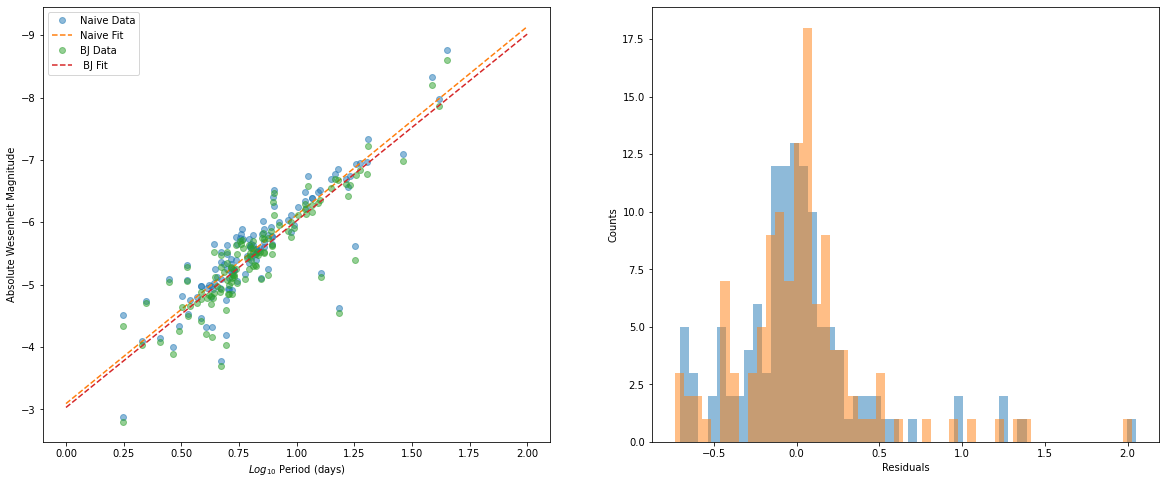

In [ ]:
optimisedFit(gaiaDF_PWR, 10, p0_naive, p0_naive)

In [ ]:
gaiaDF_PWR.drop(gaiaDF_PWR[gaiaDF_PWR.parallax / gaiaDF_PWR.parallax_error < 10].index, inplace=True)

The following two cells looks like:

$$\pm 3\sigma= \text{mean } \pm3\cdot\text{std}$$

Followed by applying the `poly_func` with the assignment coefficients for the polynomial and the log$_{10}$ of the period for the y-data.

We then found the residuals with:
$$\sigma_{bj} = \text{dist}_{wes} - Y$$

Followed by filtering the data in the dataframes for $\pm 3\sigma $.

Naive distances

In [ ]:
# Defining variables using the results from the previous section for the naive distances:
p0best_naive = [p0_naive[0], p0_naive[1]] # Optimised fitting coefficients for the line
residuals_mean_naive = 0.006540715541214188  # Mean value for the residuals taken from the previous cell output
residuals_stdev_naive = 0.41223657613363934  # Standard deviation for the residuals taken from the previous cell output

# Calculating the +/- 3 sigma values from the mean:
plus3sigma_naive = residuals_mean_naive + 3*residuals_stdev_naive
minus3sigma_naive = residuals_mean_naive - 3*residuals_stdev_naive

gaiaDF_PWR_naive = gaiaDF_PWR.copy(deep=True) # Creating a data frame that will be used for the naive distances (reasoning stated above).

# Going through the same process to find the residuals as in the 'optimisedFit' function:
poly_func_naive = polyN(p0best_naive)
yFit_naive = poly_func_naive(np.log10(gaiaDF_PWR_naive.pf))
residuals_bj = gaiaDF_PWR_naive.WesenheitAbsMag_Naive - yFit_naive
gaiaDF_PWR_naive['Residuals_Naive'] = residuals_bj

# Filtering out the outliers with residuals greater than 3-sigma from the mean:
gaiaDF_PWR_naive = gaiaDF_PWR_naive.loc[gaiaDF_PWR_naive["Residuals_Naive"] > minus3sigma_naive]
gaiaDF_PWR_naive = gaiaDF_PWR_naive.loc[gaiaDF_PWR_naive["Residuals_Naive"] < plus3sigma_naive]

Bailer-Jones distances

In [ ]:
# Defining variables using the results from the previous section for the Bailer-Jones distances:
p0best_bj = [p0_bj[0], p0_bj[1]]
residuals_mean_bj = 0.0344874917728542
residuals_stdev_bj = 0.41114413334203254

# Calculating the +/- 3 sigma values from the mean:
plus3sigma_bj = residuals_mean_bj + 3*residuals_stdev_bj
minus3sigma_bj = residuals_mean_bj - 3*residuals_stdev_bj

gaiaDF_PWR_bj = gaiaDF_PWR.copy(deep=True)  # Creating a data frame that will be used for the Bailer-Jones distances (reasoning stated above).

# Going through the same process to find the residuals as in the 'optimisedFit' function:
poly_func_bj = polyN(p0best_bj)
yFit_bj = poly_func_bj(np.log10(gaiaDF_PWR_bj.pf))
residuals_bj = gaiaDF_PWR_bj.WesenheitAbsMag_bjDist - yFit_bj
gaiaDF_PWR_bj['Residuals_BJ'] = residuals_bj

# Filtering out the outliers with residuals greater than 3-sigma from the mean:
gaiaDF_PWR_bj = gaiaDF_PWR_bj.loc[gaiaDF_PWR_bj["Residuals_BJ"] > minus3sigma_bj]
gaiaDF_PWR_bj = gaiaDF_PWR_bj.loc[gaiaDF_PWR_bj["Residuals_BJ"] < plus3sigma_bj]

In [ ]:
# Running the optimisation for the filtered data frames in the previous cell:
optValues_naive = op.fmin(chisq, p0best_naive, args=(np.log10(gaiaDF_PWR_naive.pf), gaiaDF_PWR_naive.WesenheitAbsMag_Naive,
                                                     gaiaDF_PWR_naive.WesenheitAbsMag_Naive_error), full_output=1, disp=1)
optValues_bj = op.fmin(chisq, p0best_bj, args=(np.log10(gaiaDF_PWR_bj.pf), gaiaDF_PWR_bj.WesenheitAbsMag_bjDist,
                                               gaiaDF_PWR_bj.WesenheitAbsMag_bjDist_error), full_output=1, disp=1)

# Generating a linear function using the optimised parameters from above:
poly_func_naive = polyN(optValues_naive[0])
poly_func_bj = polyN(optValues_bj[0])

Optimization terminated successfully.
         Current function value: 742.537421
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 830.872232
         Iterations: 34
         Function evaluations: 64


In [ ]:
print(f"Optimised Parameters for Naive Fit: {optValues_naive[0]} | Optimised ChiSq Value: {optValues_bj[1]}")
print(f"Optimised Parameters for BJ Fit: {optValues_bj[0]} | Optimised ChiSq Value: {optValues_bj[1]}")

Optimised Parameters for Naive Fit: [-3.05588853 -3.0821696 ] | Optimised ChiSq Value: 830.8722321690184
Optimised Parameters for BJ Fit: [-2.98620409 -3.05775116] | Optimised ChiSq Value: 830.8722321690184


After filtering the data beyond $3\sigma$, we can see the $\chi^2$ value decreased by 15% and 18% for the Naive and Bailer Jones distances, respectively. Using `fmin` has improved the fit.

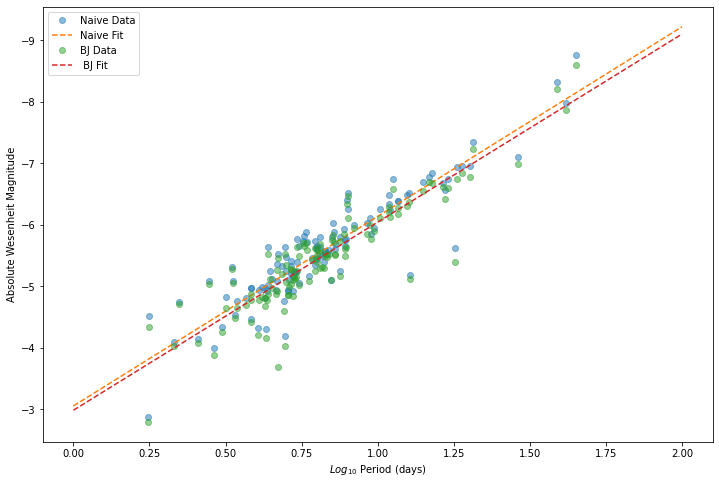

In [ ]:
# Plotting the data with their corresponding optimised linear fits:
plt.figure(figsize=(12,8))
plt.plot(np.log10(gaiaDF_PWR_naive.pf), gaiaDF_PWR_naive.WesenheitAbsMag_Naive, 'o', alpha=0.5, label='Naive Data')
plt.plot(np.linspace(0,2,100), poly_func_naive(np.linspace(0,2,100)),'--', label='Naive Fit')

plt.plot(np.log10(gaiaDF_PWR_bj.pf), gaiaDF_PWR_bj.WesenheitAbsMag_bjDist, 'o', alpha=0.5, label='BJ Data')
plt.plot(np.linspace(0,2,100), poly_func_bj(np.linspace(0,2,100)),'--', label=' BJ Fit')

# Applying appropriate label axes and legend for the data and optimised fits:
plt.xlabel("$Log_{10}$ Period (days)")
plt.ylabel("Absolute Wesenheit Magnitude")
plt.gca().invert_yaxis()
plt.legend()


# 8. Using MCMC to determine best fit parameters and associated uncertainties.



We will now use an MCMC sampler to fit the straight line model to our data. Similar to that seen in lectorial 4, we will use a module called [emcee](https://emcee.readthedocs.io/en/stable/). This is a pure Python implementation of an MCMC sampler that makes many guesses in parallel.

First, you need to import emcee from the Imports folder.

Second, you need to define a function that now returns the log-likelihood, which will be maximised by the emcee sampler. Hint: recall $ln((\mathcal{L}) = -\chi^2/2.$

Once you have this set up, you can follow the procedure outlined in the Lectorial 4 notebook to run the MCMC sample, but modified for the simpler straight-line fit. You should produce plots that show how your chains evolve, and to determine where convergence has occured. Then, rerun your fit now starting at the final position of the first emcee run. From this fit, determine the best fit parameters and their uncertainties using the flattened version of the chain for each fitted parameter.

In [ ]:
# Defining a function that returns the log-likelihood of a polynomial fit:
def logLikelihood(p, xData, yData, yerrData):
  return -0.5 * chisq(p, xData, yData, yerrData)

Definitions:
- Walkers: visualising each guess as a time-series of positions in paramater space that 'walk' all over the parameter space. The guesses are spread over the parameter space instead of going to a minimum point. So the walkers 'walk' across the parameter-space to reach the best-fit value.
- Burn in: The burn in period visualises the history of each walker to see when they reach the right area of the parameter space.
- Chain: gives the history of where the walkers moved during the run.


In [ ]:
# Importing MCMC and initialising setup parameters:
from Imports import emcee

nWalkers = 100 # Number of walkers that will be used to maximise the log-likelihood of the linear fit.
ndim = 2 # A linear function requires 2 coefficients.
nBurnSteps = 1000 # Number of steps taken for each walker.

# Assume that no good initial guesses were made for the linear fit. This will result in long calculation times.
# This generates random numbers taken from a uniform-distribution between 0 (inclusive) and 1 (exclusive).
p0 = [np.random.rand(ndim) for i in range(nWalkers)]

# Establishing the sampler for each distance measurement:
samplerNaive = emcee.EnsembleSampler(nwalkers=nWalkers, dim=ndim, lnpostfn=logLikelihood,
                                      args=[np.log10(gaiaDF_PWR_naive.pf),gaiaDF_PWR_naive.WesenheitAbsMag_Naive,gaiaDF_PWR_naive.WesenheitAbsMag_Naive_error],
                                     threads=2)
samplerBJ = emcee.EnsembleSampler(nwalkers=nWalkers, dim=ndim, lnpostfn=logLikelihood,
                                  args=[np.log10(gaiaDF_PWR_bj.pf),gaiaDF_PWR_bj.WesenheitAbsMag_bjDist,gaiaDF_PWR_bj.WesenheitAbsMag_bjDist_error],
                                  threads=2)

# Running the sampler:
posNaive, probNaive, stateNaive = samplerNaive.run_mcmc(pos0=p0, N=nBurnSteps, storechain=True)
posBJ, probBJ, stateBJ = samplerBJ.run_mcmc(pos0=p0, N=nBurnSteps, storechain=True)

Text(0.06, 0.5, 'Parameter Likeliness')

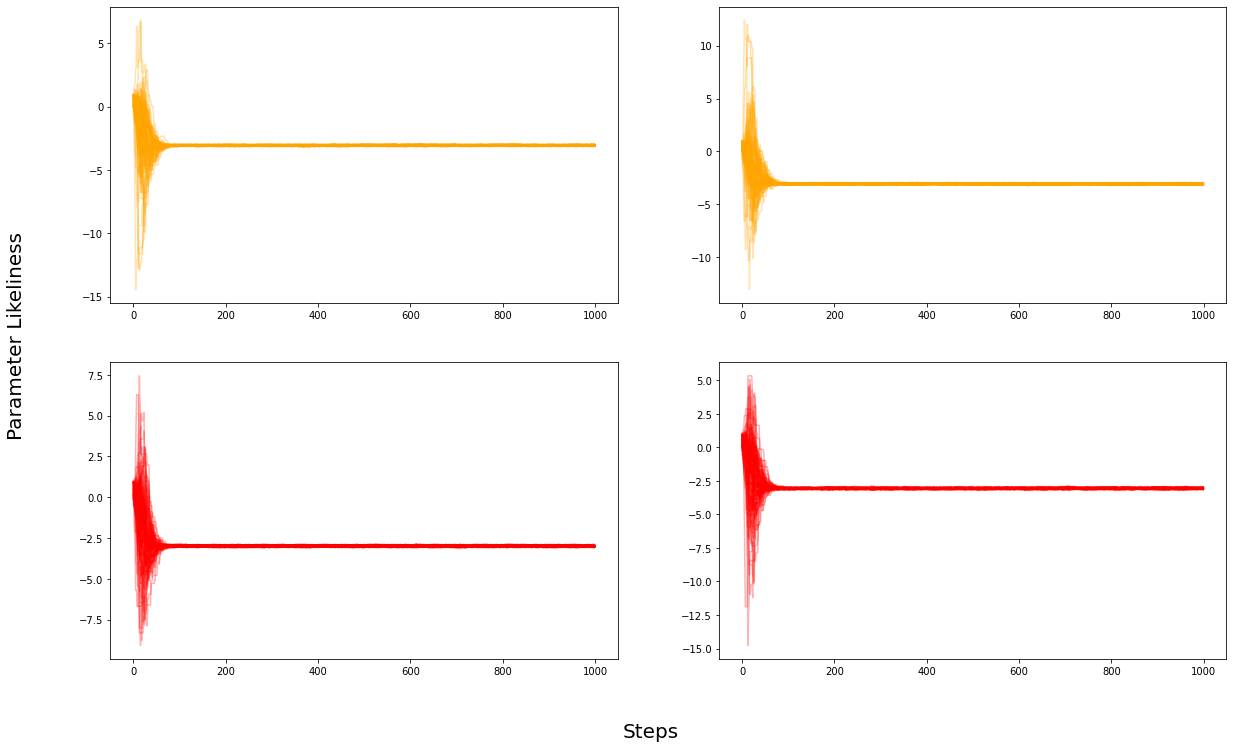

In [ ]:
# Plotting the paths that the walkers have taken to reach the parameters that maximise the log-likelihood:
fig = plt.figure()
fig.set_size_inches([20,12])

for j in range(ndim):
  ax_1 = fig.add_subplot(ndim,2,j+1)
  chainsNaive = samplerNaive.chain[:,:,j].transpose() # Extracting the paths taken by the walkers.
  ax_1.plot(chainsNaive, color='orange', alpha=0.3) # Orange corresponds to the naive distances.

for j in range(ndim):
  ax_2 = fig.add_subplot(ndim,2,j+3)
  chainsBJ = samplerBJ.chain[:,:,j].transpose()
  ax_2.plot(chainsBJ, color='red', alpha=0.3) # Red corresponds to the Bailer-Jones distances.

fig.text(0.5, 0.04, 'Steps', ha='center', va='center', size = 20)
fig.text(0.06, 0.5, 'Parameter Likeliness', ha='center', va='center', rotation='vertical', size= 20)

For all plots, the walkers converge around 100.

Resetting the samplers so that we can rerun it at the position of convergence found previously `posNaive` and `posBJ`. This will allow us to find the best fit params and uncertainties.

In [ ]:
nSteps = 1000
# Resetting the samplers:
samplerNaive.reset()
samplerBJ.reset()

# Re-running the sampler with the results from the first run:
posNaiveFinal, probNaiveFinal, stateNaiveFinal = samplerNaive.run_mcmc(pos0=posNaive, N=nSteps, storechain=True)
posBJFinal, probBJFinal, stateBJFinal = samplerBJ.run_mcmc(pos0=posBJ, N=nSteps, storechain=True)

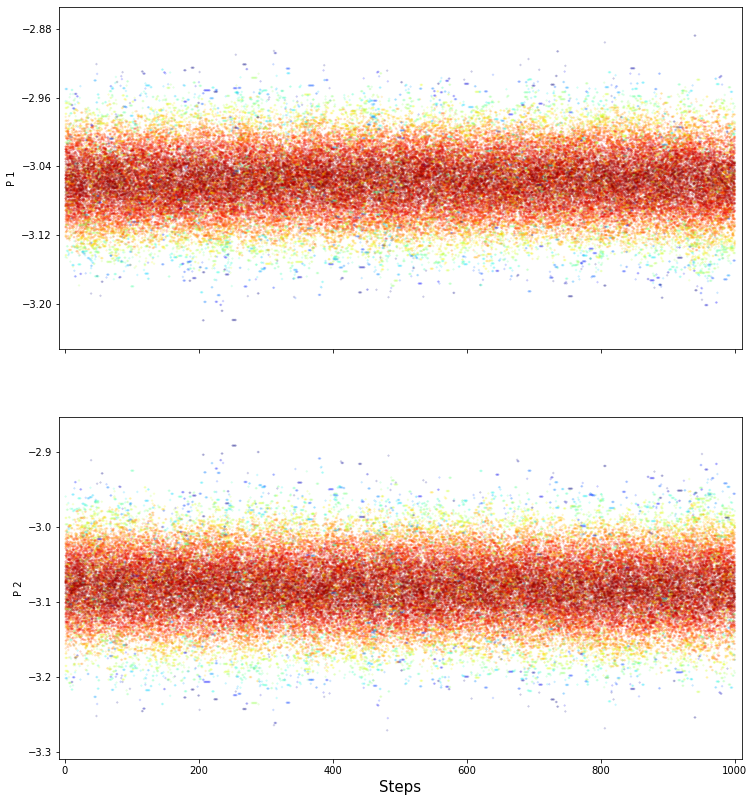

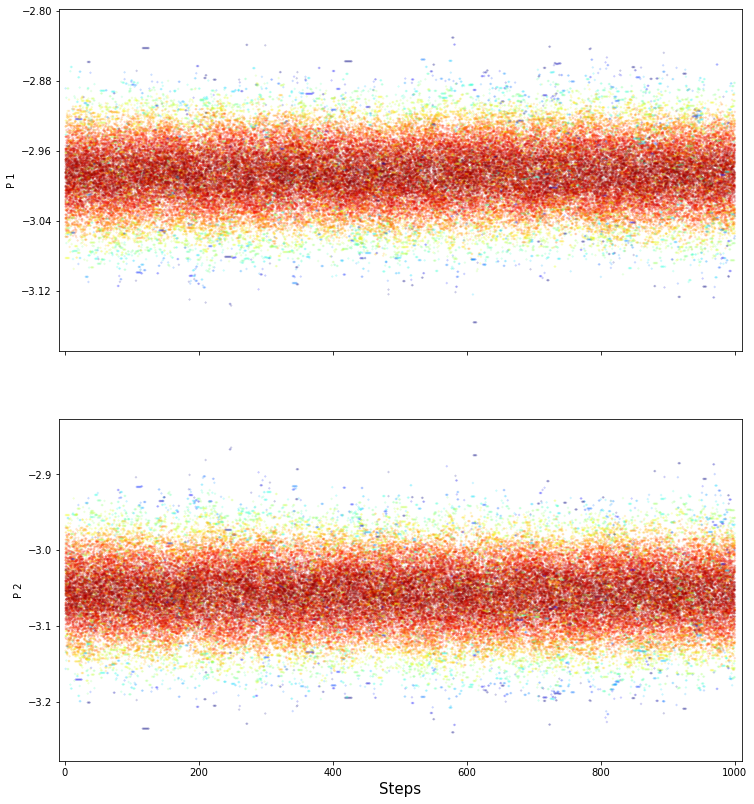

In [ ]:
# Plotting the distributions of the values for the best parameters.
# Red colours show high likelihoods while blue colours show low likelihoods.
from Imports.util_tute04 import plot_trace

plot_trace(samplerNaive) # First two plots correspond to the naive distances.
plot_trace(samplerBJ) # Last two plots correspond to the Bailer-Jones distances.

Each param is centered around a value. A histogram of these plots would be the posterior likelihood distribution of the params.

Retrieving the best fit params for the linaer fit and their uncertainties:

In [ ]:
# Creating empty lists which will be populated with the best-fit parameters and associated uncertainties:
pBest_Naive = []
pErr_Naive = []
pBest_BJ = []
pErr_BJ = []

# Determining the best parameters and associated uncertainties calculated by the sampler for the naive distances:
for i in range(ndim):
  fChain = samplerNaive.flatchain[:,i] # Placing all the parameter values calculated by the sampler into a 1D-array.
  neg1sig, mean, pos1sig = np.percentile(fChain,[16,50,84]) # Finding the mean and 1 standard deviation of the parameter values.
  pBest_Naive.append(mean) # Placing the mean value (i.e. best parameter value) into the above list.

  errLow = mean - neg1sig # -1 sigma from mean
  errHigh = pos1sig - mean # +1 sigma from mean
  standardError = np.mean([errLow, errHigh]) # Since the two sigma values are not equidistant from the mean, we take the average.
  pErr_Naive.append((standardError)) # Placing the mean of the standard deviations into the above list.
  print(f"Parameter (Naive): {i}, pBest: {mean}, Error: {standardError}")

# Determining the best parameters and associated uncertainties calculated by the sampler for the Bailer-Jones distances:
for j in range(ndim):
  fChain = samplerBJ.flatchain[:,j]
  neg1sig, mean, pos1sig = np.percentile(fChain,[16,50,84])
  pBest_BJ.append(mean)

  errLow = mean - neg1sig
  errHigh = pos1sig - mean
  standardError = np.mean([errLow, errHigh])
  pErr_BJ.append(standardError)
  print(f"Parameter (BJ): {j}, pBest: {mean}, Error: {standardError}")

Parameter (Naive): 0, pBest: -3.0578903694918216, Error: 0.0381885565246185
Parameter (Naive): 1, pBest: -3.0797374497972783, Error: 0.045489458697535845
Parameter (BJ): 0, pBest: -2.986954929085409, Error: 0.03741611258869604
Parameter (BJ): 1, pBest: -3.057237952074714, Error: 0.044325225214636665


These values are similar to those found in section 7, which we used 3$\sigma$ to filter out the values.

Plotting the best fit params found with the samplers

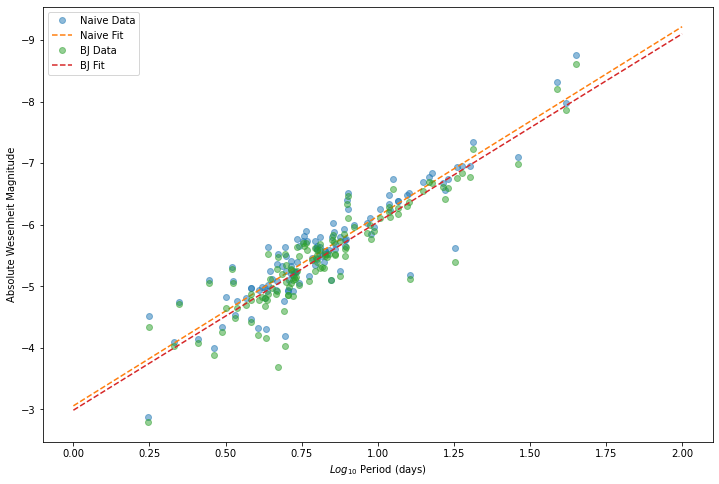

In [ ]:
# Generating a linear function with the best-fit parameters calculated above:
polyFunc_Naive = polyN(pBest_Naive)
polyFunc_BJ = polyN(pBest_BJ)

# Plotting the data points with the best linear fits:
plt.figure(figsize=(12,8))

plt.plot(np.log10(gaiaDF_PWR_naive.pf), gaiaDF_PWR_naive.WesenheitAbsMag_Naive,'o', alpha=0.5, label='Naive Data')
plt.plot(np.linspace(0,2,100), polyFunc_Naive(np.linspace(0,2,100)),'--', label='Naive Fit')

plt.plot(np.log10(gaiaDF_PWR_bj.pf), gaiaDF_PWR_bj.WesenheitAbsMag_bjDist,'o', alpha=0.5, label='BJ Data')
plt.plot(np.linspace(0,2,100), polyFunc_BJ(np.linspace(0,2,100)),'--', label='BJ Fit')

plt.xlabel("$Log_{10}$ Period (days)")
plt.ylabel("Absolute Wesenheit Magnitude")
plt.gca().invert_yaxis()
plt.legend()

Plotting the sampler fit and the $3\sigma$ fit

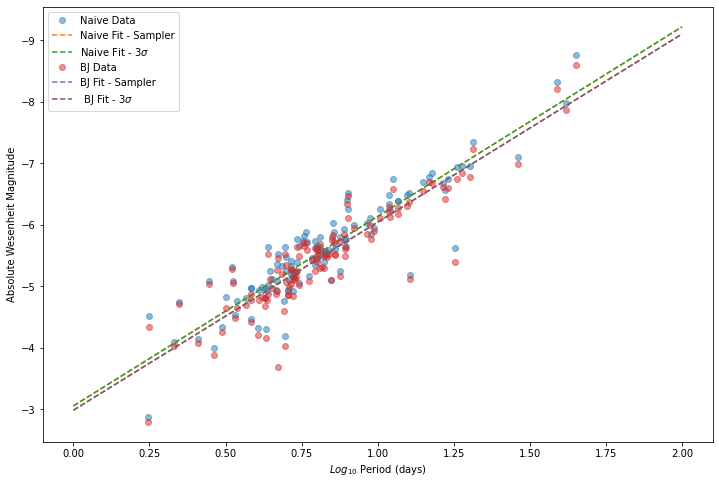

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(np.log10(gaiaDF_PWR_naive.pf), gaiaDF_PWR_naive.WesenheitAbsMag_Naive,'o', alpha=0.5, label='Naive Data')
plt.plot(np.linspace(0,2,100), polyFunc_Naive(np.linspace(0,2,100)),'--', label='Naive Fit - Sampler')
plt.plot(np.linspace(0,2,100), poly_func_naive(np.linspace(0,2,100)),'--', label='Naive Fit - $3\sigma$')

plt.plot(np.log10(gaiaDF_PWR_bj.pf), gaiaDF_PWR_bj.WesenheitAbsMag_bjDist,'o', alpha=0.5, label='BJ Data')
plt.plot(np.linspace(0,2,100), polyFunc_BJ(np.linspace(0,2,100)),'--', label='BJ Fit - Sampler')
plt.plot(np.linspace(0,2,100), poly_func_bj(np.linspace(0,2,100)),'--', label=' BJ Fit - $3\sigma$')

plt.xlabel("$Log_{10}$ Period (days)")
plt.ylabel("Absolute Wesenheit Magnitude")
plt.gca().invert_yaxis()
plt.legend()



Both methods of fits are almost identical.

# 9. Use your calibrated PWR to determine the distance to the LMC


Select all delta cepheids in the LMC using a box in galactic coordinates defined by $l=(273,285)$, $b=(-38, -28)$. Use the best-fitting results from your final calibrated PWR (use the Bailer-Jones PWR), as well as the periods and apparent $W_{G}$ magnitudes to determine the distance to the LMC.

To do this, you can do the following:
* determine the predicted $M_W$ for all Cepheid periods in the LMC, then measure the difference between the predicted value and the apparent $W_{G}$ magnitude. This effectively gives the distance modulus for each Cepheid, from which a sample of distance moduli and, hence, distances can be determined.
* The mean/median and standard deviation/percentiles of the distance distribution give a measure of the distance to the LMC, and the associated uncertainties.
* Given your measured distance, would it be possible to use Gaia DR2 parallaxes to determine the distance to the LMC?



Using the best fitting results from the previous section `pBest_BJ` to create a polynomial

In [ ]:
# Again, creating a linear function that predicts the absolute Wesenheit magnitude given the value of the period (logarithm).
wesenheitPredicted = polyN(pBest_BJ)

In [ ]:
# Creating a new data frame which selects Classical Cepheids in the given galactic latitude and longitude range for the LMC:
# finds delta cepheids in the coordinates, rather than all the cepheids.
LMC_DF = cleanCepData[cleanCepData.l >= 273]
LMC_DF = LMC_DF[LMC_DF.l <= 285]
LMC_DF = LMC_DF[LMC_DF.b >= -38]
LMC_DF = LMC_DF[LMC_DF.b <= -28]

Text(0, 0.5, 'Galactic Latitude')

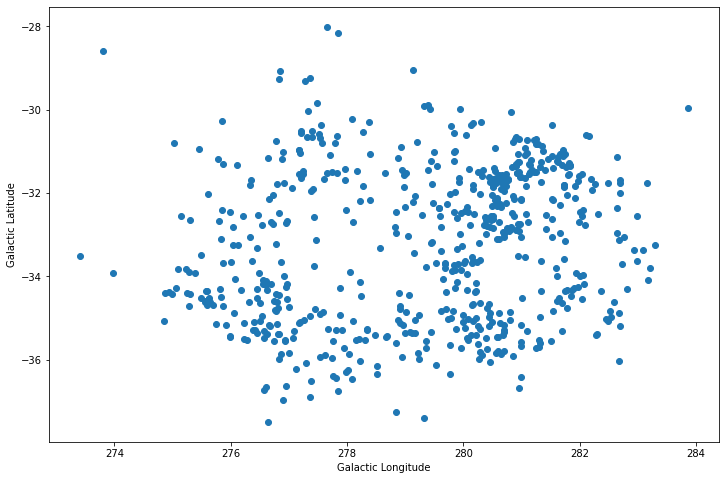

In [ ]:
# Plotting the galactic longitudes and latitudes of the sources in the LMC:
plt.figure(figsize=(12,8))

plt.plot(LMC_DF.l,LMC_DF.b,'o')

plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')

Using the definition of the Wesenheit magnitude
$$W(G,BP,RP)= G - 19\cdot(BP-RP)$$

In [ ]:
# The apparent Wesenheit magnitudes for each source:
wesenheitMag_LMC = LMC_DF.int_average_g - 1.9*(LMC_DF.int_average_bp - LMC_DF.int_average_rp)

Distance modulus:
$$m - M= M_W - W_G$$
$$\therefore d= 10^{0.2(m-M+5)}$$

In [ ]:
# The distance modulus for each source:
LMC_distMod = wesenheitMag_LMC - wesenheitPredicted(np.log10(LMC_DF.pf))

# The distance to each source using the distance modulus:
LMC_dist = 10**(0.2*(LMC_distMod + 5))

In [ ]:
print(f"The mean distance to the LMC is: {LMC_dist.mean(): .3f} parsecs.")
print(f"The standard deviation of the distances is: {LMC_dist.std(): .3f} parsecs.")
print(f"The distance to the LMC is approximately between {LMC_dist.mean() - LMC_dist.std(): .3f} and {LMC_dist.mean() + LMC_dist.std(): .3f} parsecs.")

The mean distance to the LMC is: 58619.145565424085 parsecs.
The standard deviation of the distances is: 7407.841153712395 parsecs.
The distance to the LMC is approximately between 51211.30441171169 and 66026.98671913648 parsecs.


Using the Wesenheit magnitude to determine the distance to the LMC resulted in a distance of approximately 58.7 KPc, compared to the actual approximate distance of 50.0 KPc. Thus an accuracy of 85%.

Determining distance to the LMC from the parallaxes of the sources

In [ ]:
LMC_Parallax = LMC_DF.parallax / 1000
LMC_Distance = 1 / LMC_Parallax

print(f"The mean distance to the LMC is: {LMC_Distance.mean(): .3f} parsecs.")
print(f"The standard deviation of the distances is: {LMC_Distance.std(): .3f} parsecs.")
print(f"The distance to the LMC is approximately between {LMC_Distance.mean() - LMC_Distance.std(): .3f} and {LMC_Distance.mean() + LMC_Distance.std(): .3f} parsecs.")

The mean distance to the LMC is: 211285.83979196954 parsecs.
The standard deviation of the distances is: 2819386.899087004 parsecs.
The distance to the LMC is approximately between -2608101.0592950345 and 3030672.7388789733 parsecs.


Using the inverse parallax formula yields poor results as the distance to the LMC is greater than $10^4$. We can see a std is greater than the actual mean distance to the LMC using this method.

Using the distance modulus method with the `polyN` function had significantly more accurate results to determine the distance to the LMC.

